# Importing required packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Reading dataset

In [2]:
df_train = pd.read_csv('Training.csv')
df_train_copy = df_train.copy()

# EDA

In [3]:
#Displaying first 5 rows of dataset
df_train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [4]:
#Dataset shape
df_train.shape

(4920, 134)

In [5]:
df_train.size

659280

In [6]:
df_train.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'Unnamed: 133'],
      dtype='object', length=134)

In [7]:
# Checking for duplicates
duplicate = df_train.duplicated().sum()
print(f'Our tarining dataset has {duplicate} duplicated row')

Our tarining dataset has 4616 duplicated row


In [8]:
# checking for null values in the dataset
df_null = df_train.isna().sum().sum()
print(f'The dataset has {df_null} null variable')

The dataset has 4920 null variable


In [9]:
#Summary statistics
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
itching,4920.0,0.137805,0.344730,0.0,0.0,0.0,0.0,1.0
skin_rash,4920.0,0.159756,0.366417,0.0,0.0,0.0,0.0,1.0
nodal_skin_eruptions,4920.0,0.021951,0.146539,0.0,0.0,0.0,0.0,1.0
continuous_sneezing,4920.0,0.045122,0.207593,0.0,0.0,0.0,0.0,1.0
shivering,4920.0,0.021951,0.146539,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
inflammatory_nails,4920.0,0.023171,0.150461,0.0,0.0,0.0,0.0,1.0
blister,4920.0,0.023171,0.150461,0.0,0.0,0.0,0.0,1.0
red_sore_around_nose,4920.0,0.023171,0.150461,0.0,0.0,0.0,0.0,1.0
yellow_crust_ooze,4920.0,0.023171,0.150461,0.0,0.0,0.0,0.0,1.0


In [10]:
df_train.describe(exclude = np.number).T

,count,unique,top,freq
prognosis,4920,41,Fungal infection,120


In [11]:
df_train.dtypes

itching                   int64
skin_rash                 int64
nodal_skin_eruptions      int64
continuous_sneezing       int64
shivering                 int64
                         ...   
blister                   int64
red_sore_around_nose      int64
yellow_crust_ooze         int64
prognosis                object
Unnamed: 133            float64
Length: 134, dtype: object

## a. Data processing

In [12]:
# Dropping columns with any missing values
df_train.dropna(axis = 1, inplace = True)
df_train.isna().sum().sum()

0

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


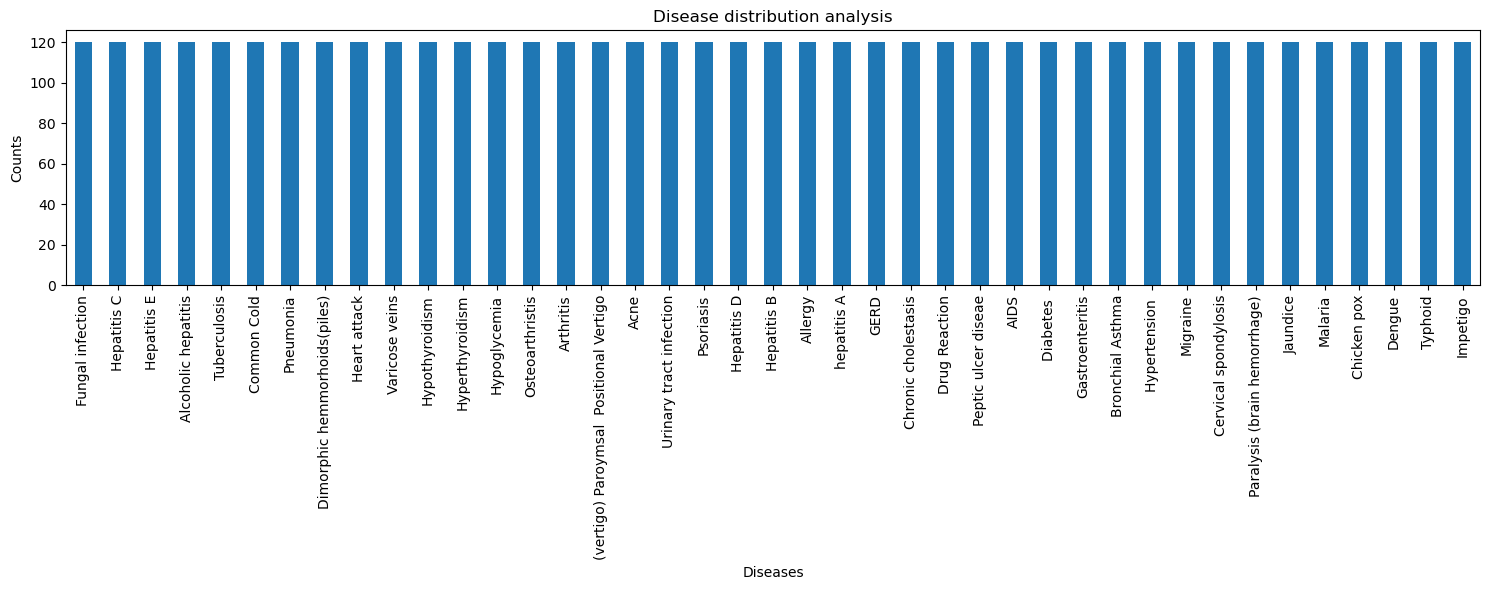

In [14]:
# Determining if dataset is balanced
plt.figure(figsize=(15,6))
disease_counts = df_train['prognosis'].value_counts().plot(kind = 'bar')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease distribution analysis')
plt.tight_layout()
plt.show()

From the plot, we can see that the dataset is balanced, with exactly 120 samples for each disease, so no further balancing is needed. The prognosis column, which is our target, is currently in an object datatype format. This format isn't suitable for training a machine learning model. Therefore, we will use a label encoder to convert the prognosis column into numerical format. The label encoder transforms the labels into numerical values by assigning a unique index to each label. If there are n labels, the assigned numbers will range from 0 to n-1.

## b. Outlier capping

In [15]:
def outlier_capping(df_outlier, threshold=1.5):
    outlier_df = df_outlier.copy()
    
    # Storing indices of outliers
    outlier_indices = []
    
    # Iterate through each column to identify and cap outliers in numerical columns
    for column in outlier_df.select_dtypes(include=np.number).columns:
        Q1 = outlier_df[column].quantile(0.25)
        Q3 = outlier_df[column].quantile(0.75)
        
        # Interquartile range
        IQR = Q3 - Q1
        
        # Lower and upper bound for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identifying outliers based on bounds
        outliers = outlier_df[(outlier_df[column] < lower_bound) | (outlier_df[column] > upper_bound)]
        outlier_indices.extend(outliers.index)
        
        # Capping outliers to upper and lower bounds
        outlier_df[column] = np.where(outlier_df[column] < lower_bound, lower_bound, outlier_df[column])
        outlier_df[column] = np.where(outlier_df[column] > upper_bound, upper_bound, outlier_df[column])
        
    # Removing duplicate outlier indices
    outlier_indices = list(set(outlier_indices))

    # Return the DataFrame with capped outliers and the list of outlier indices
    return outlier_df, outlier_indices
    
df_train_clean, outliers = outlier_capping(df_train)

To verify the effectiveness of outlier capping, we will create boxplots for each column before and after the capping process to compare the results.

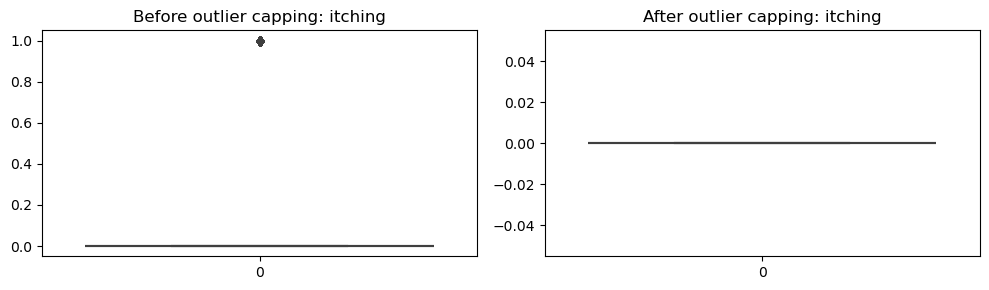

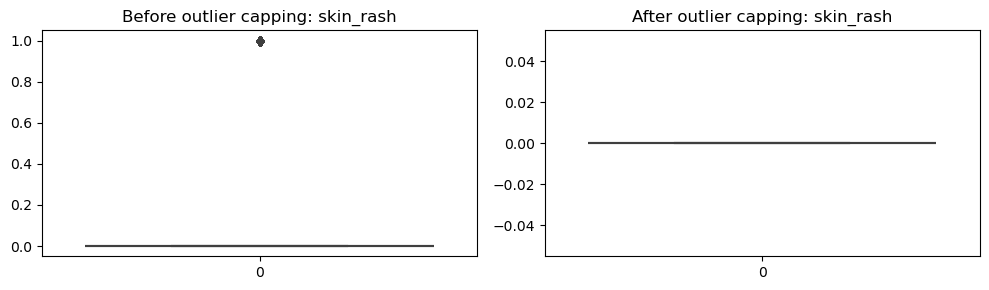

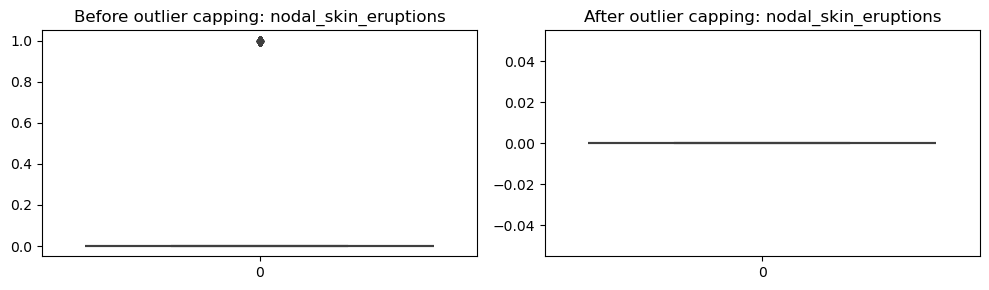

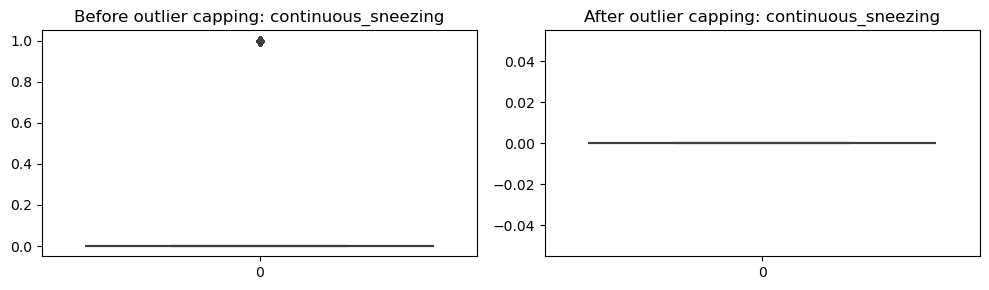

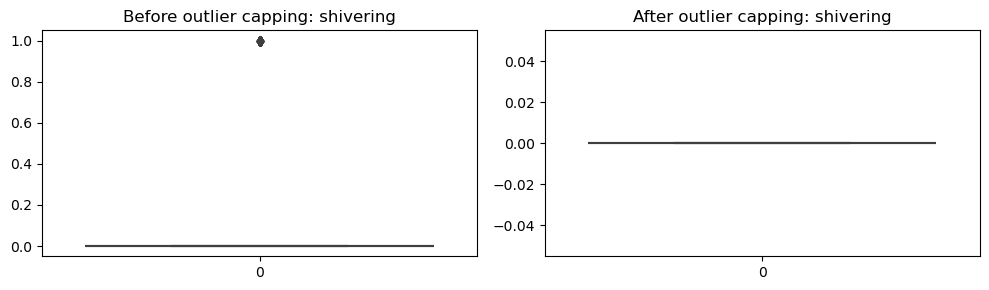

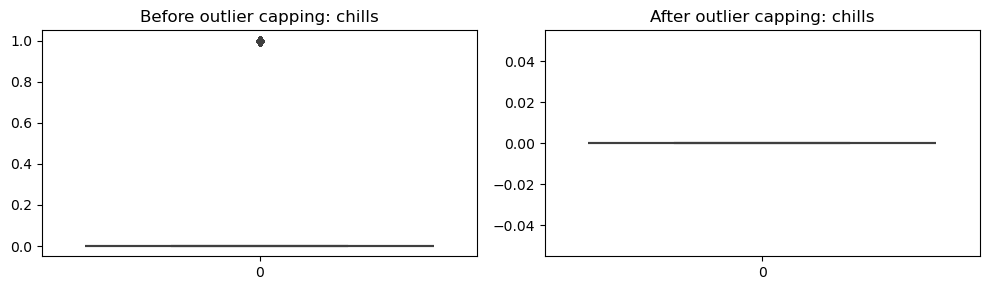

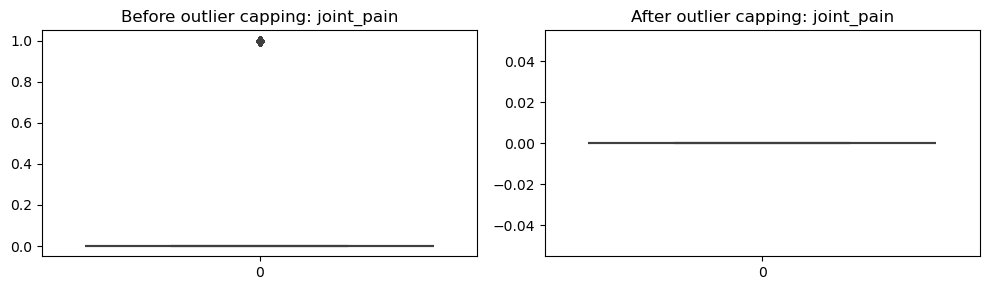

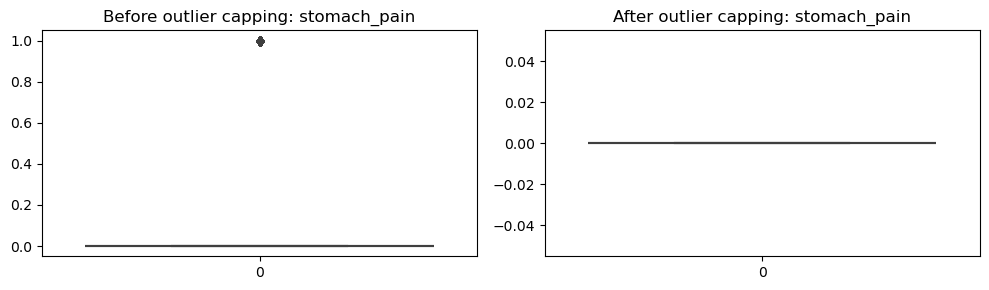

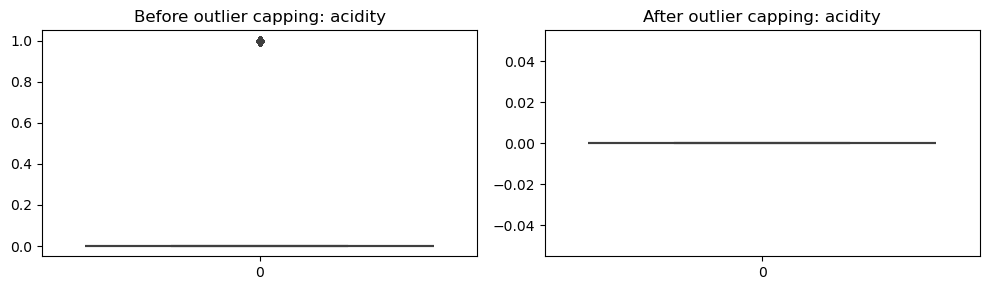

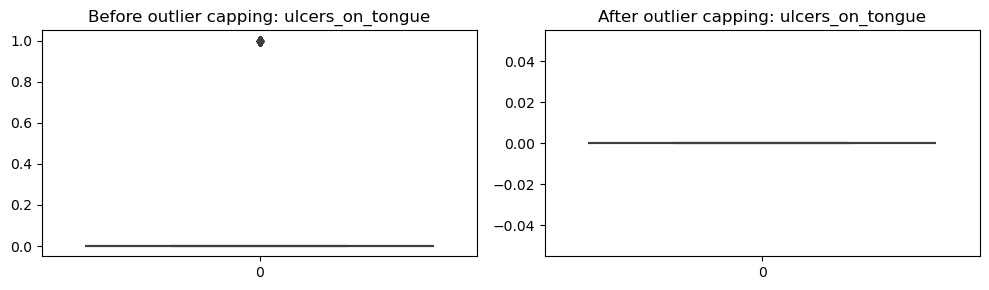

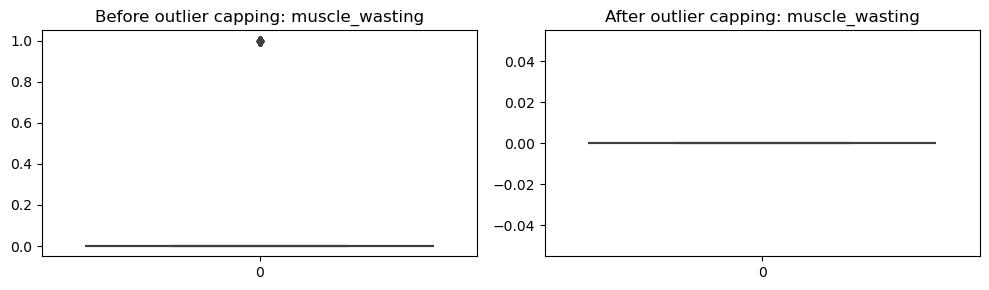

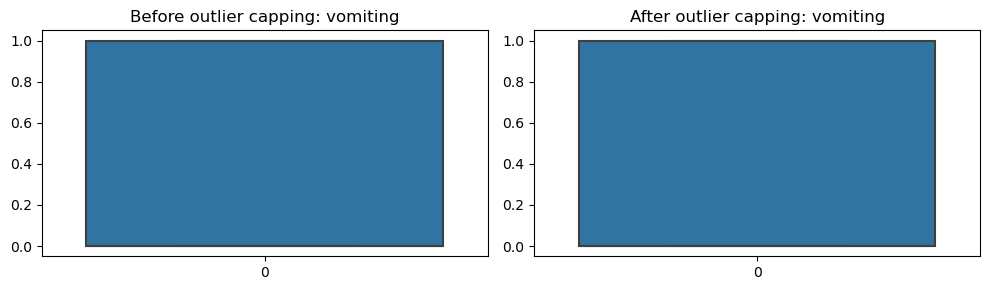

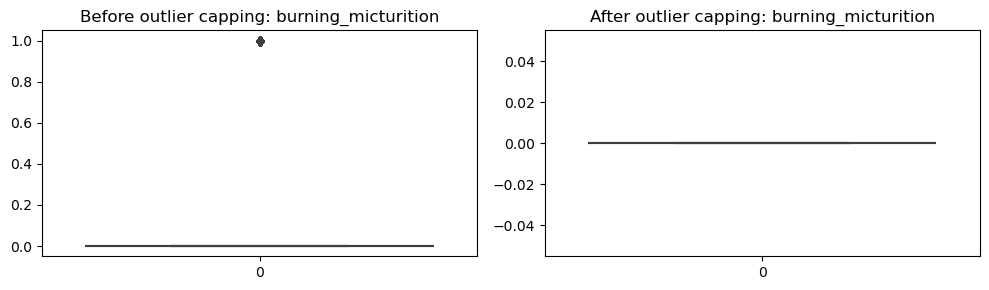

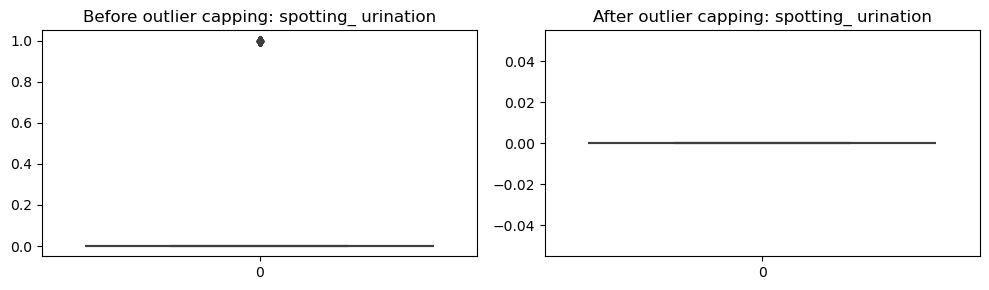

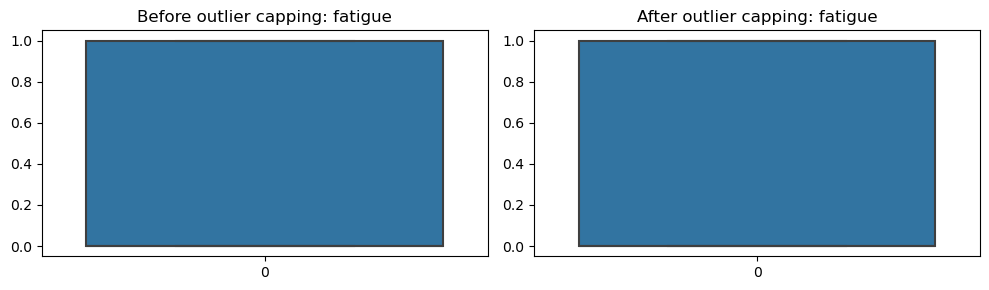

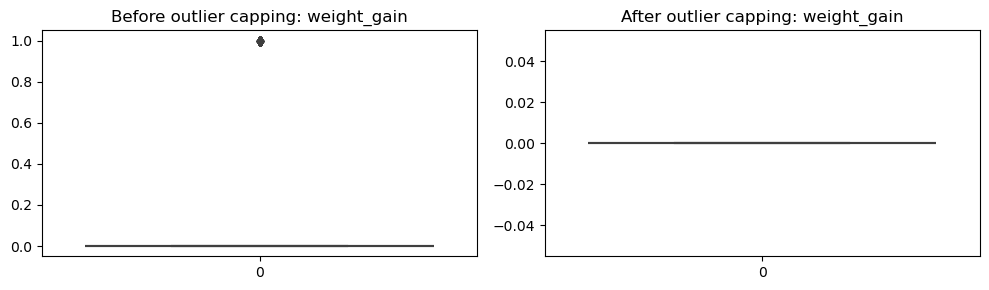

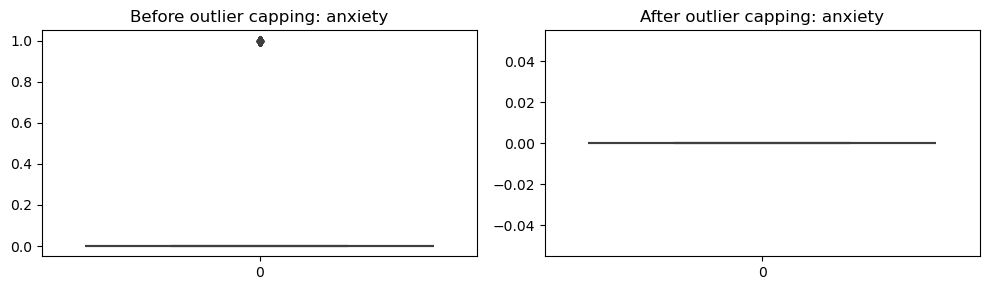

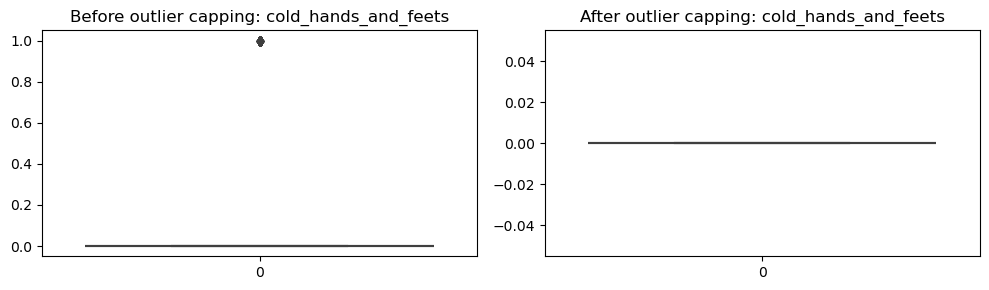

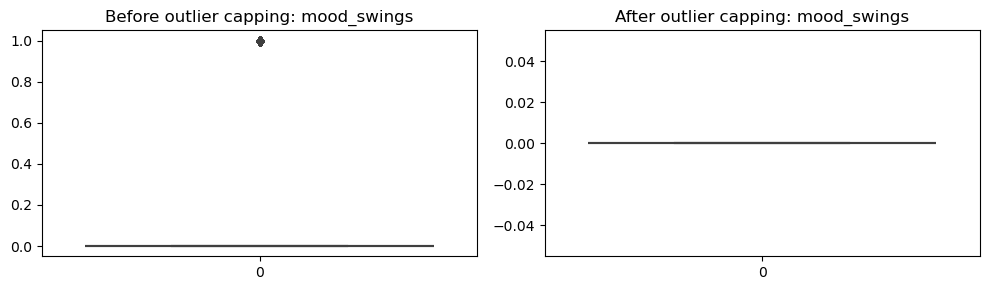

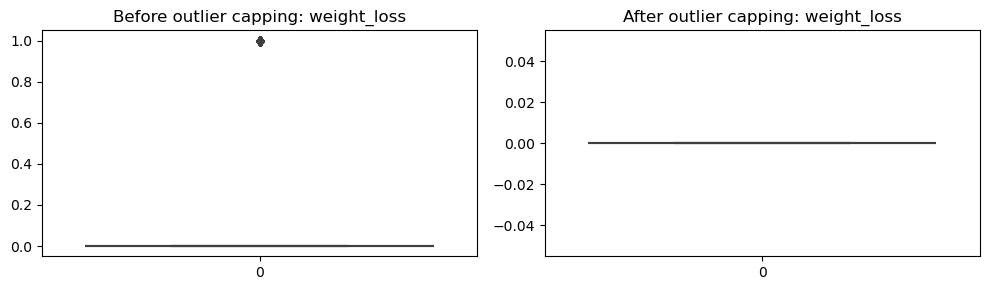

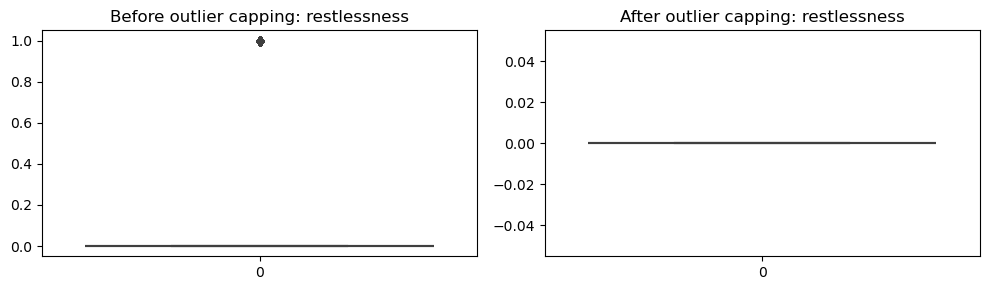

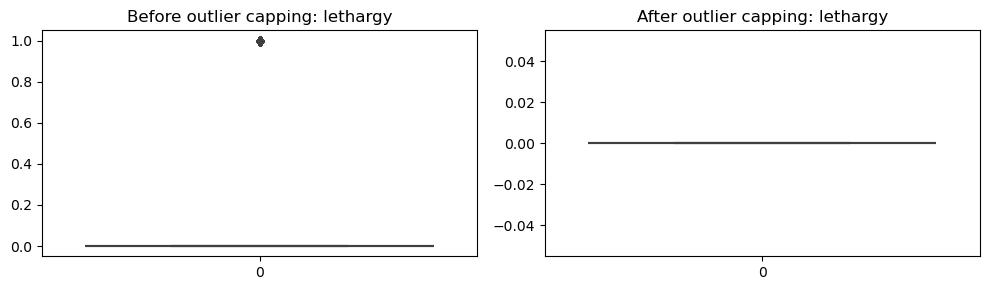

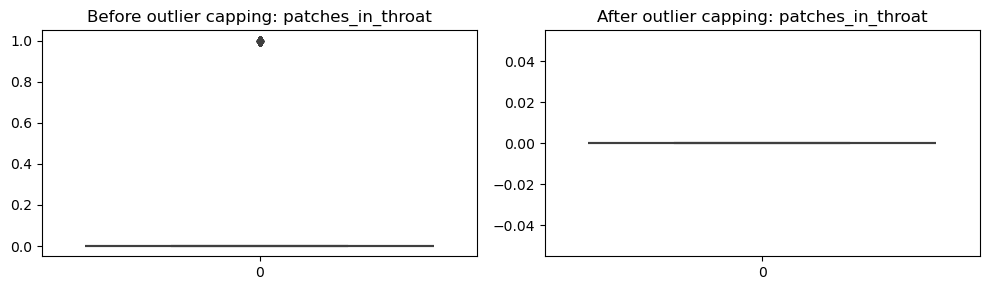

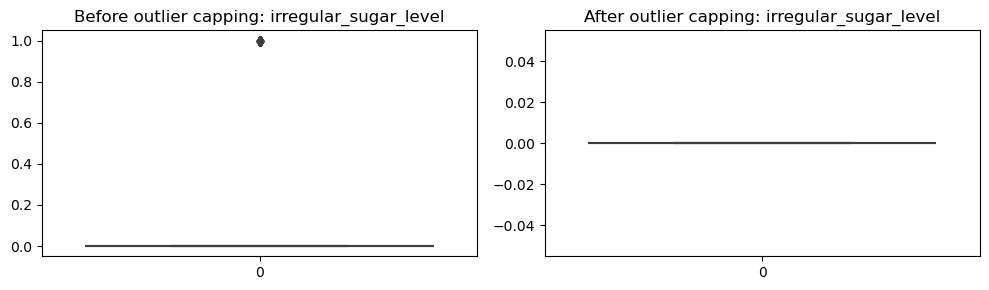

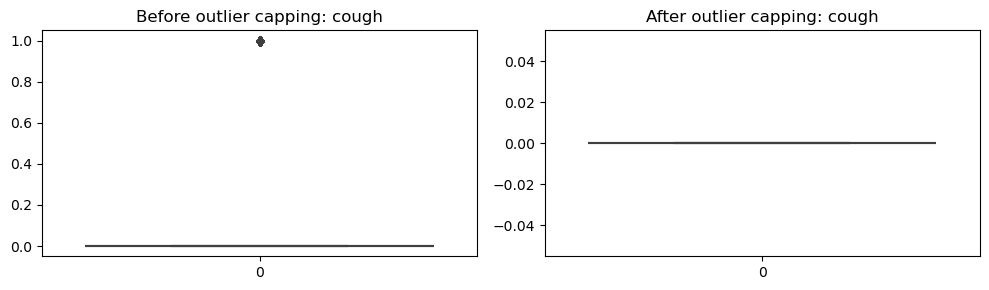

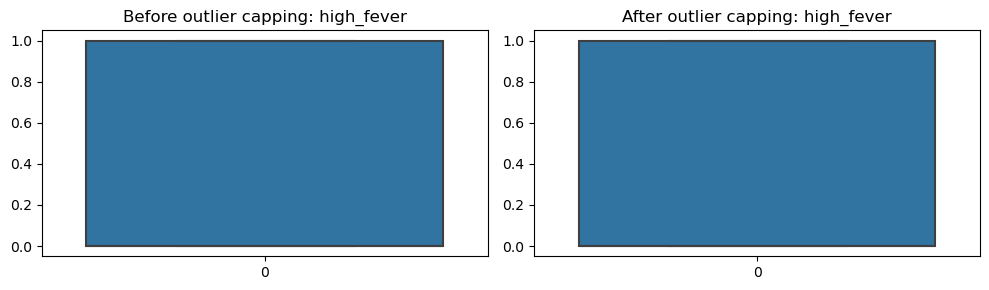

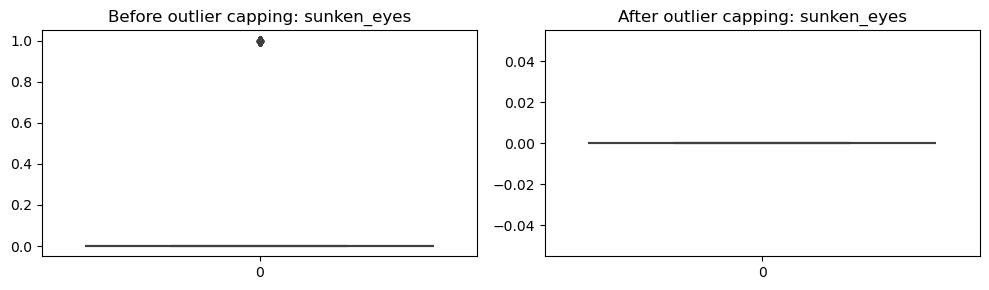

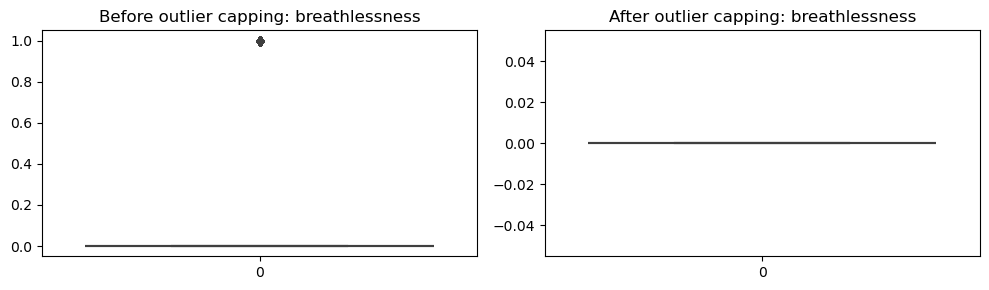

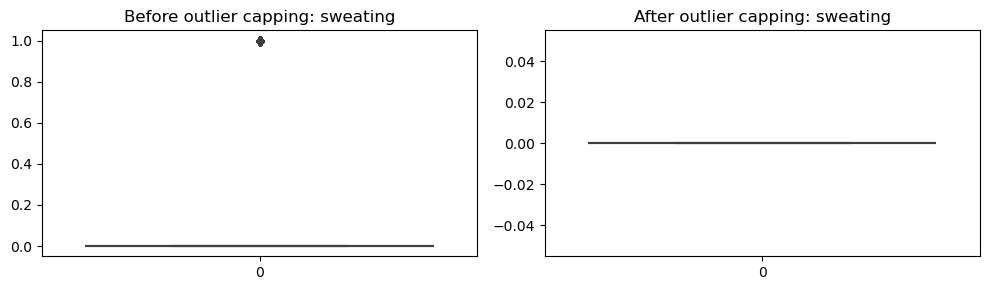

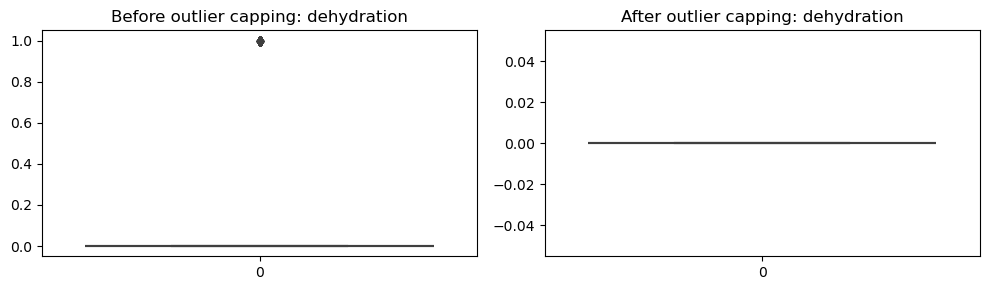

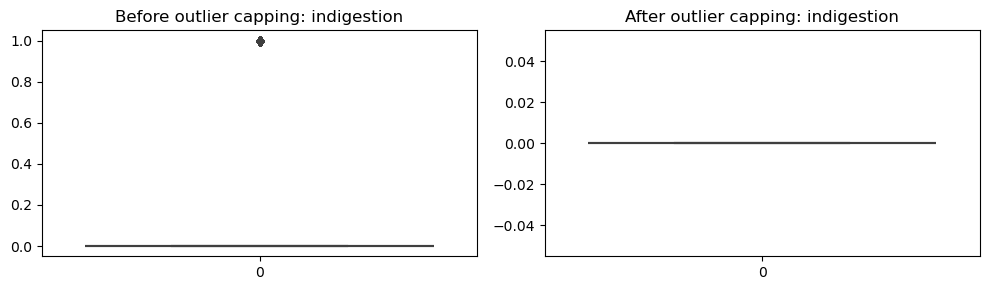

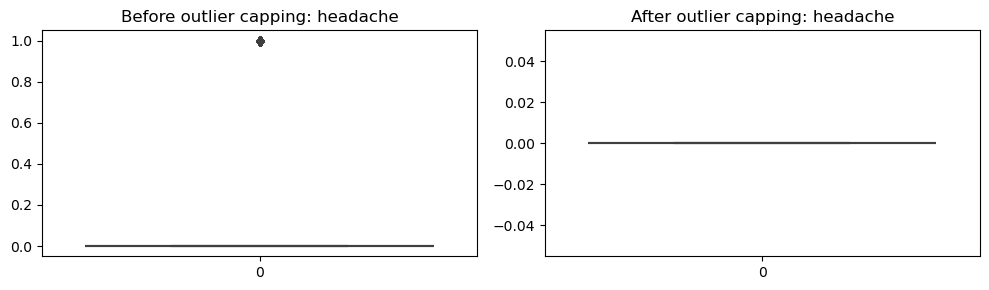

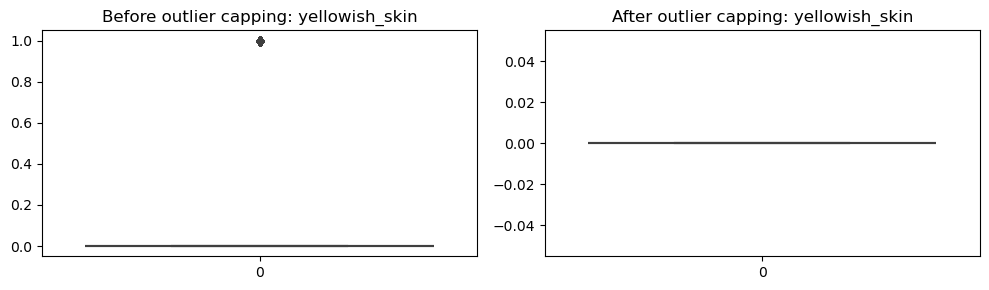

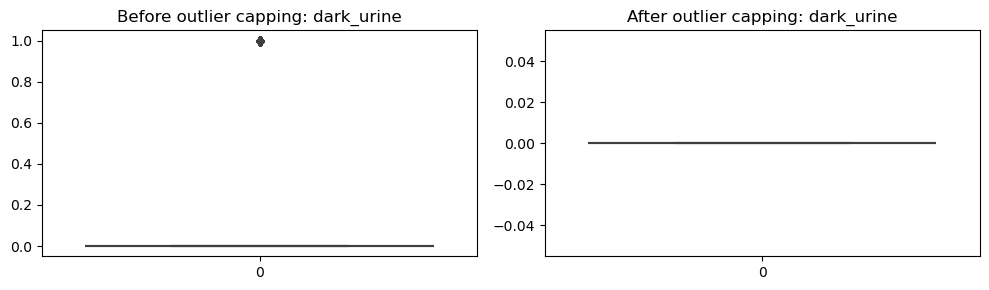

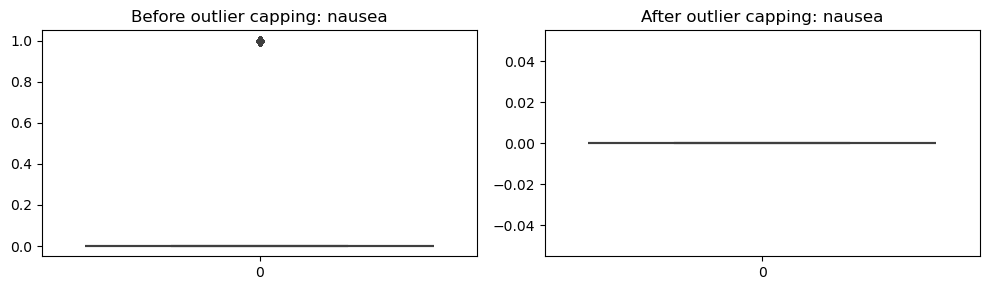

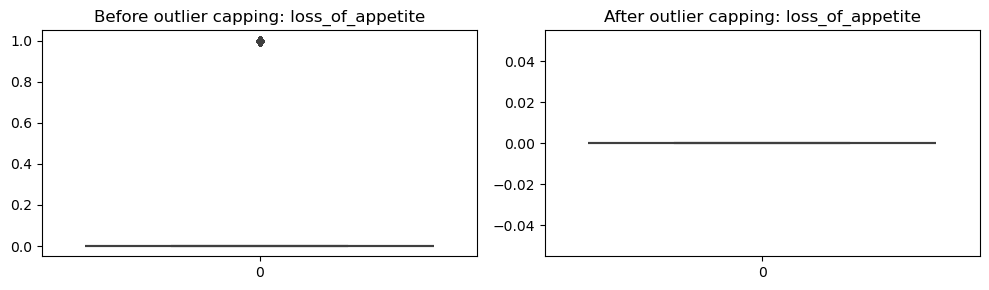

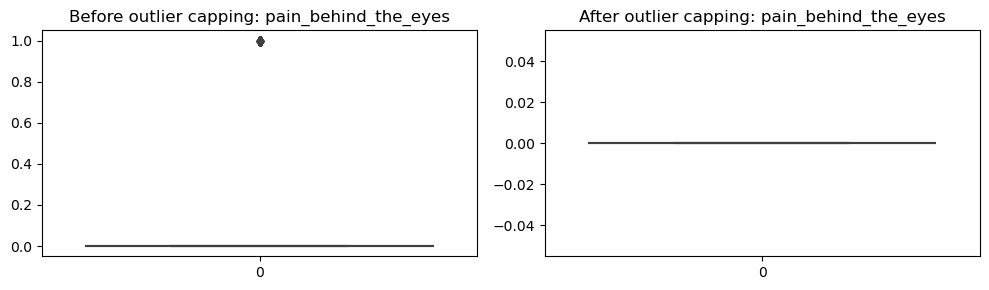

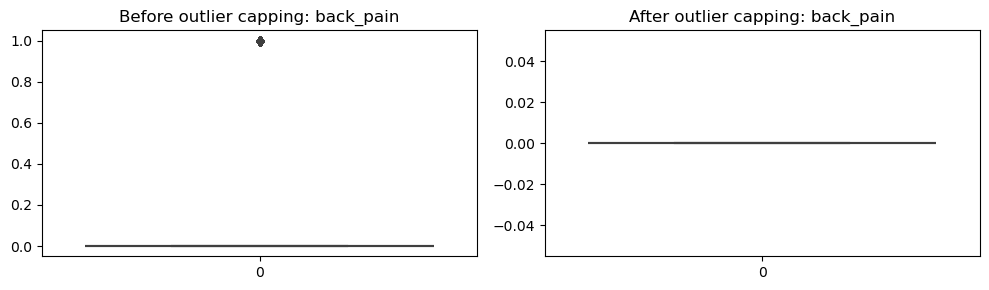

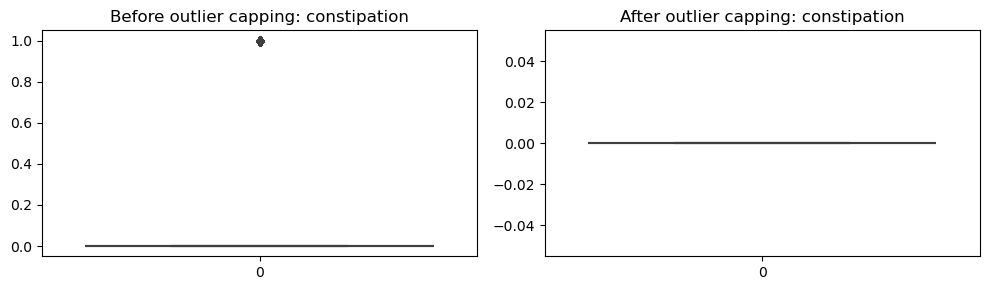

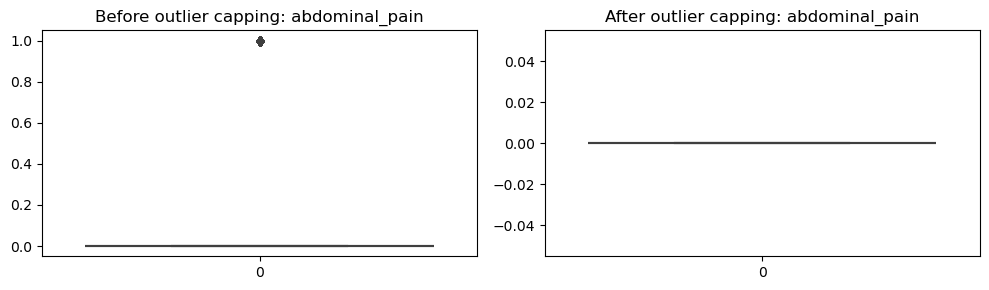

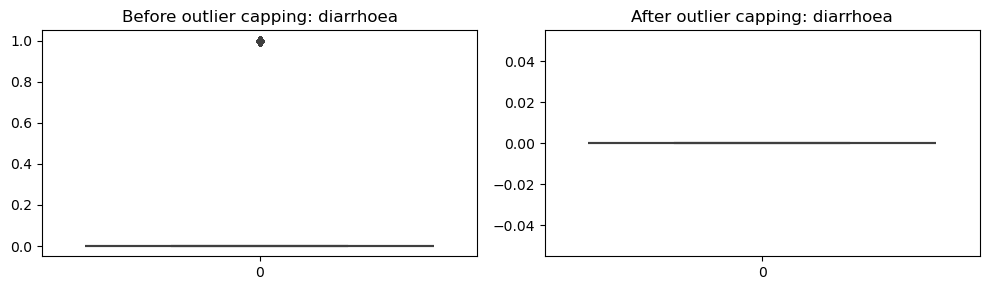

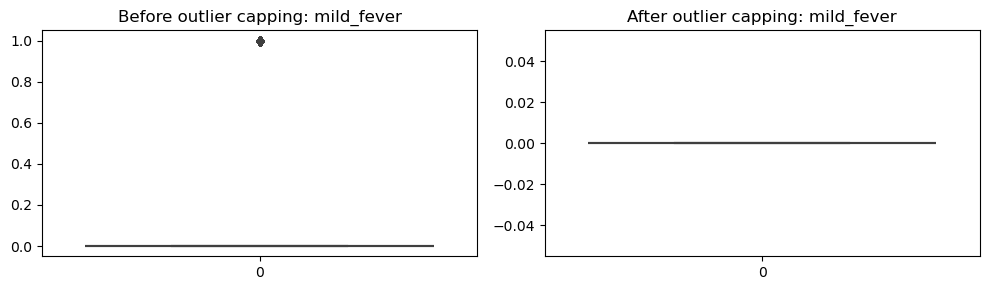

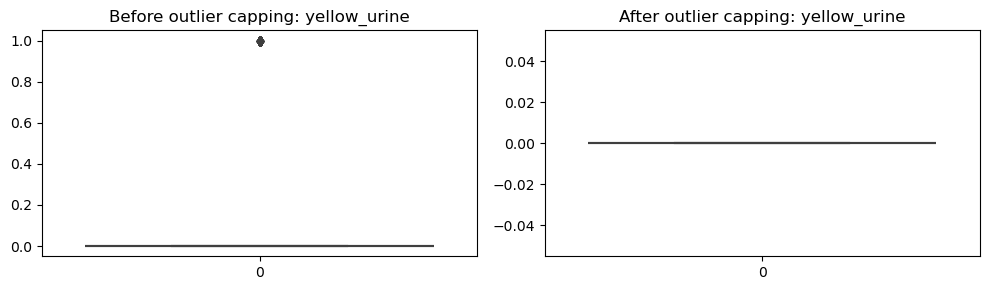

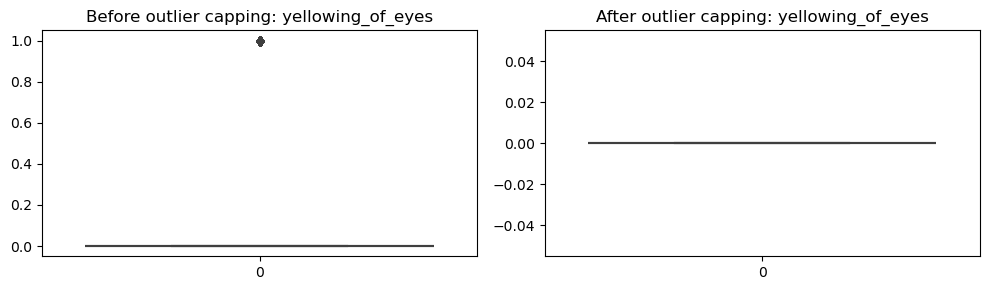

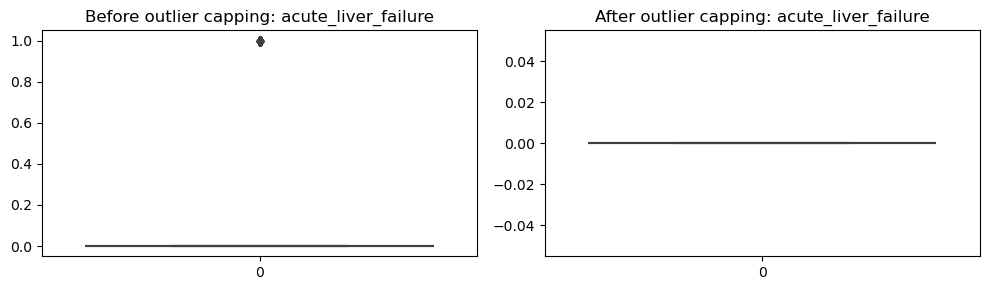

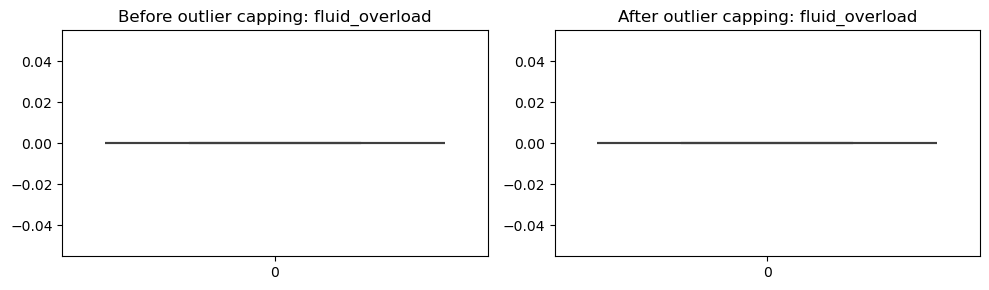

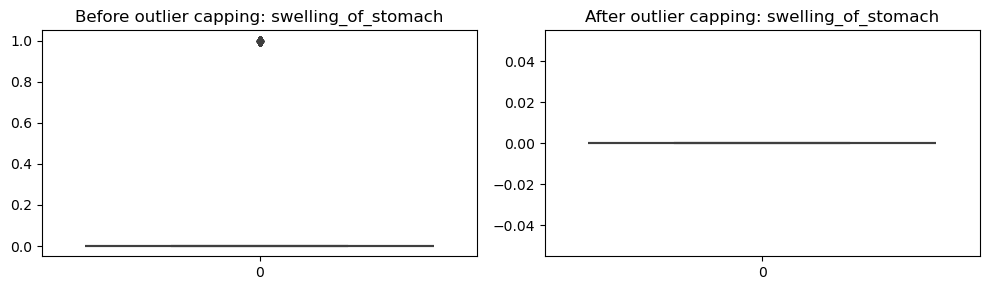

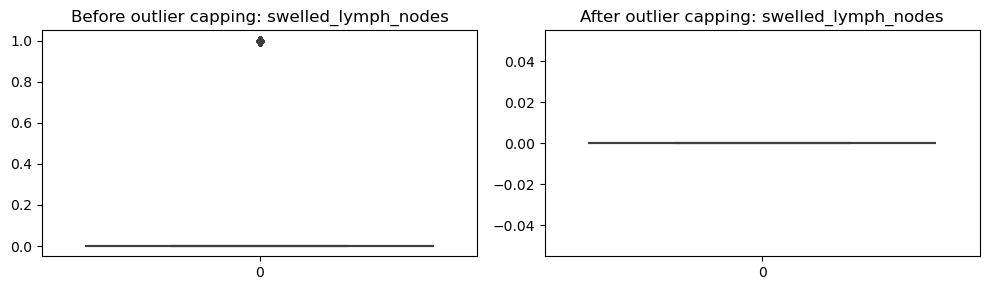

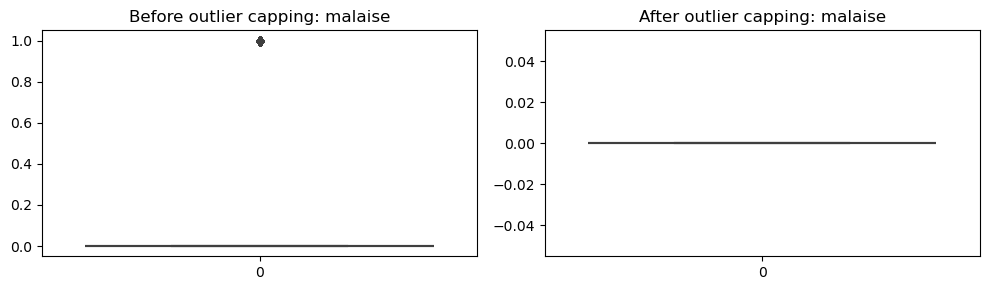

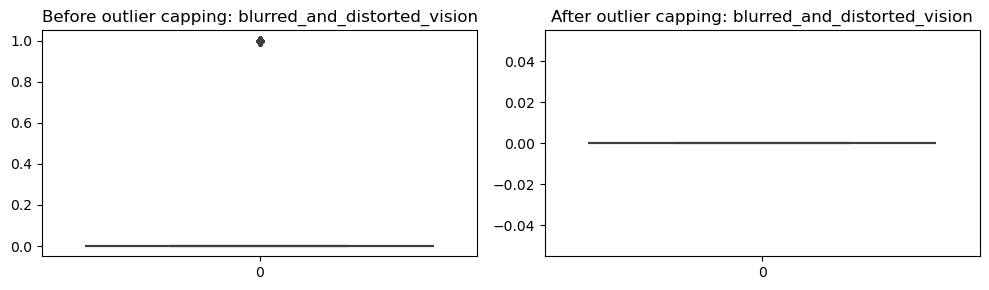

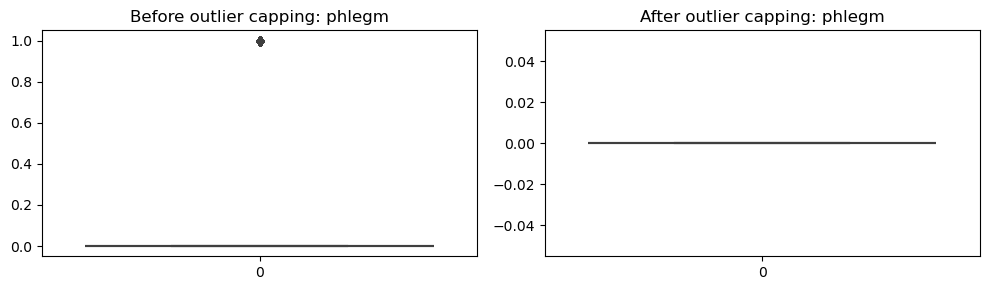

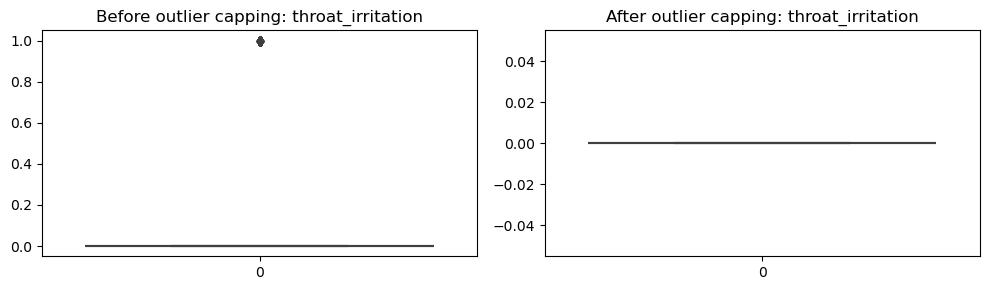

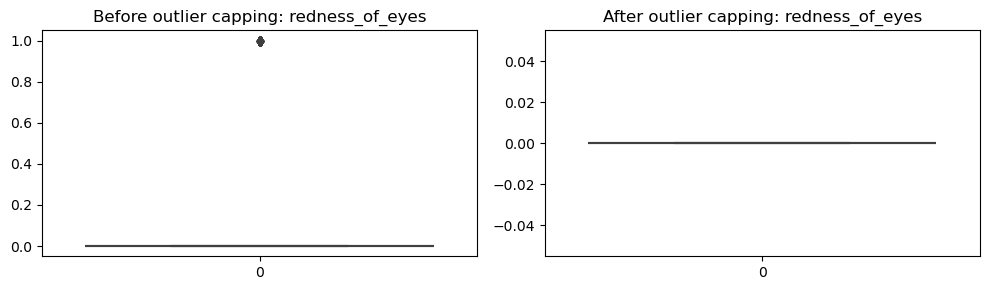

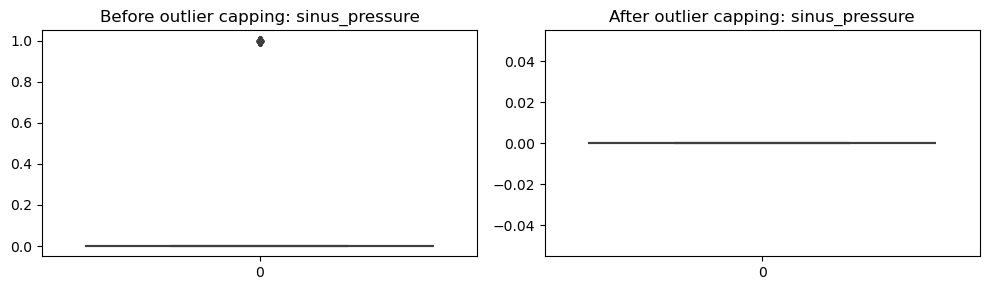

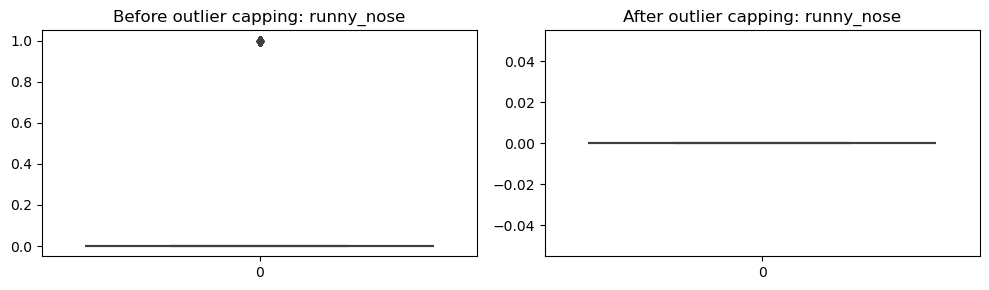

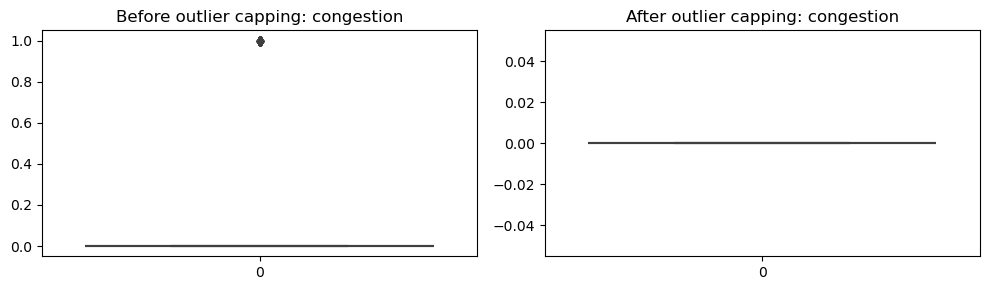

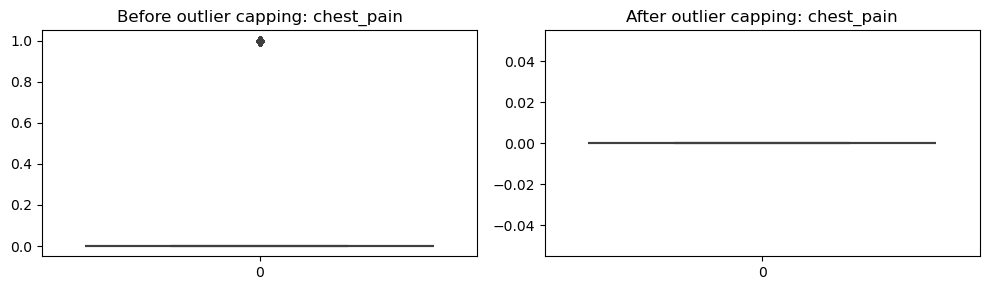

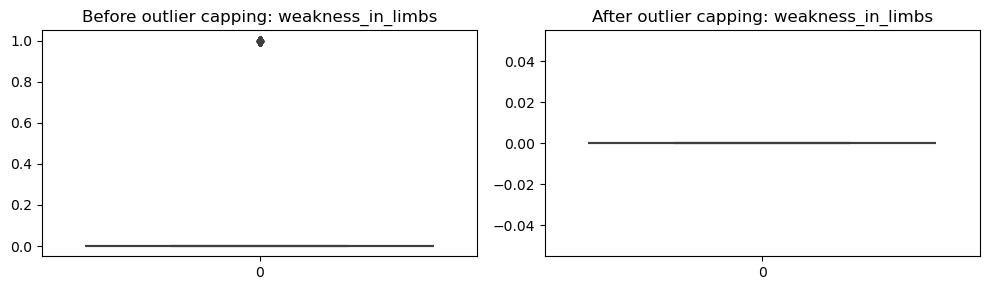

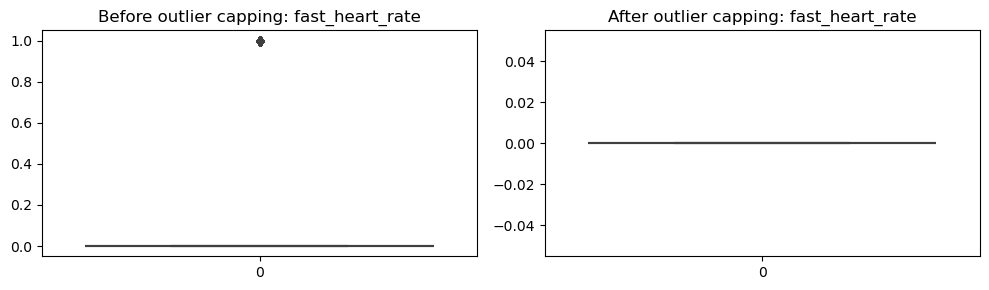

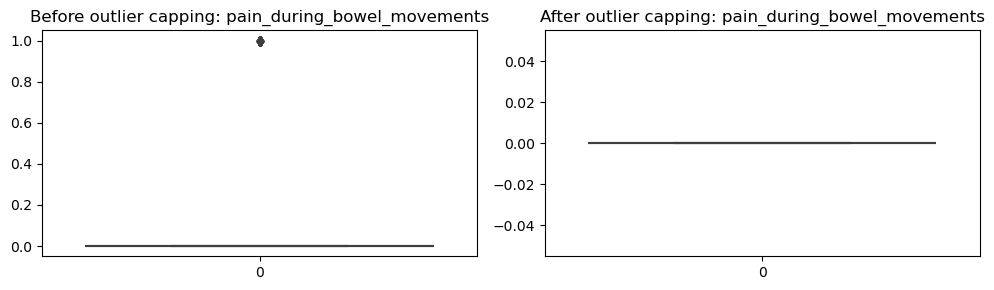

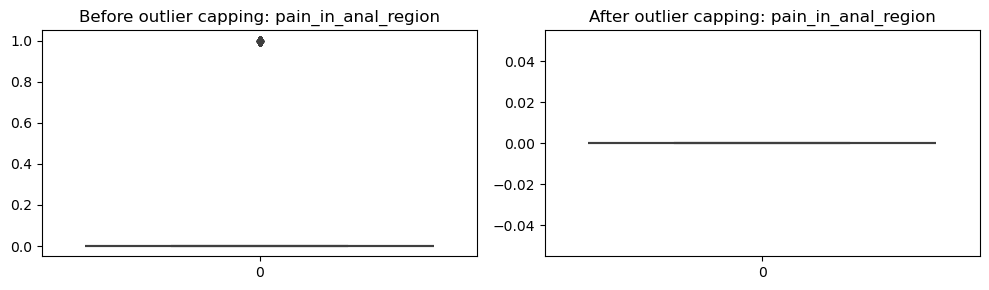

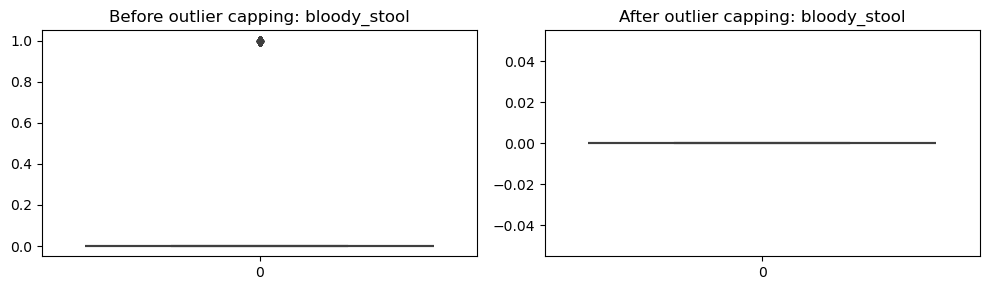

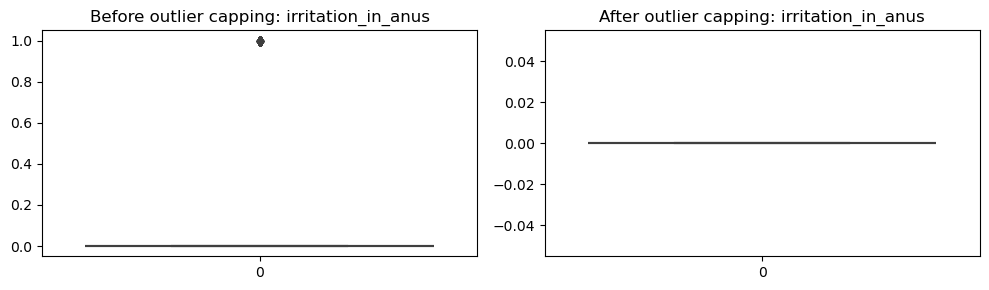

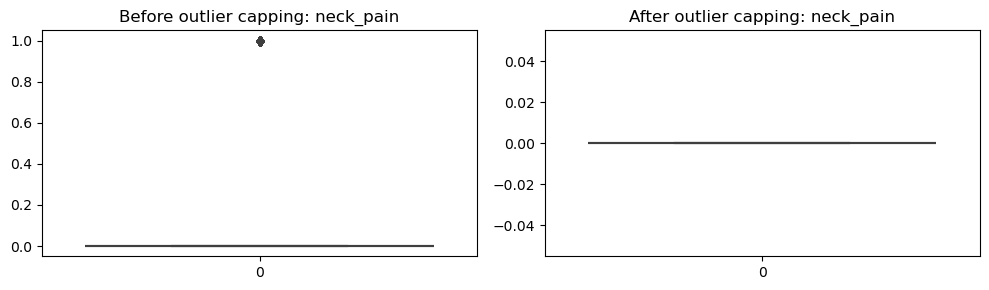

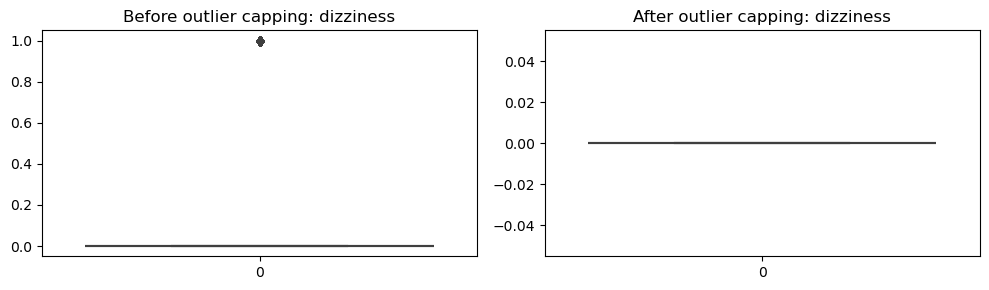

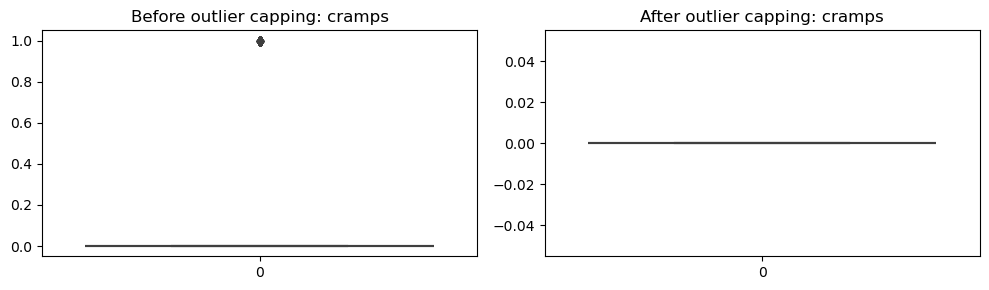

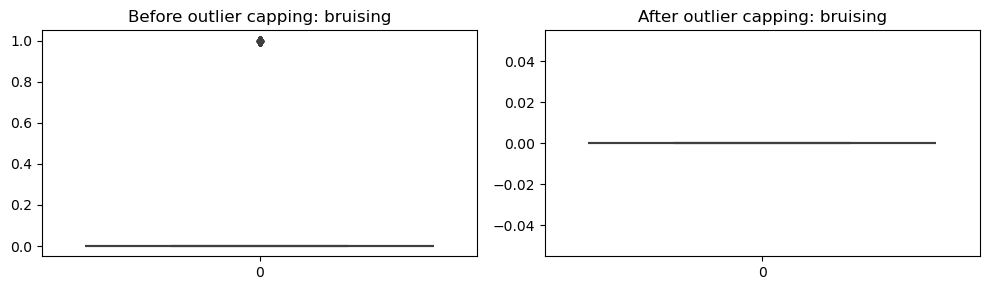

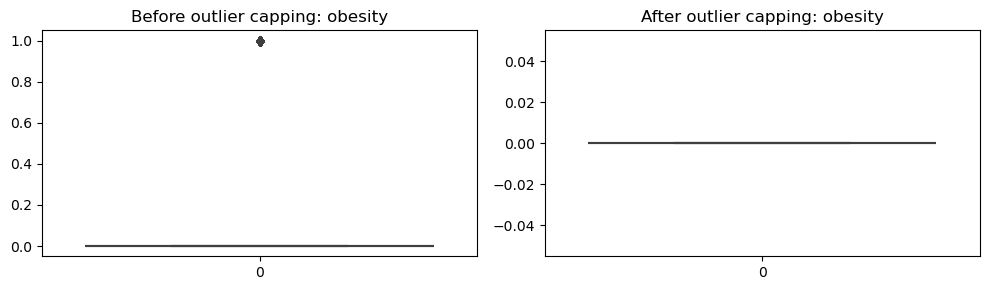

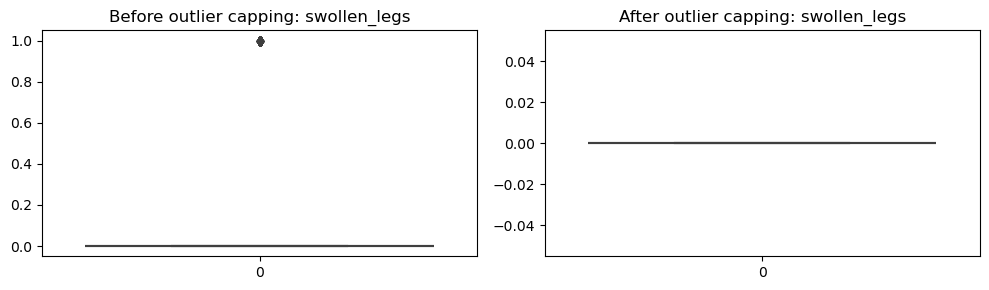

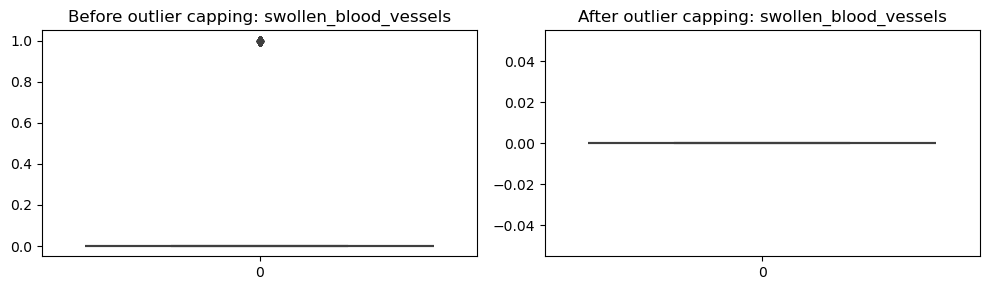

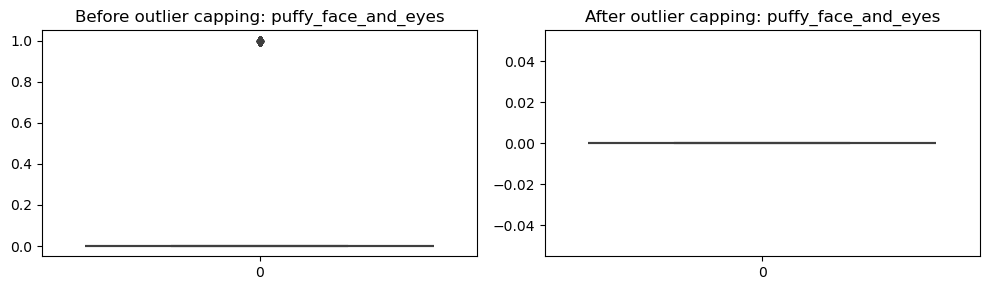

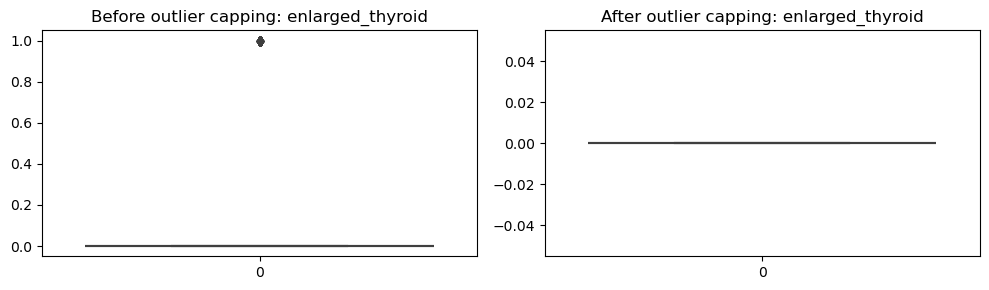

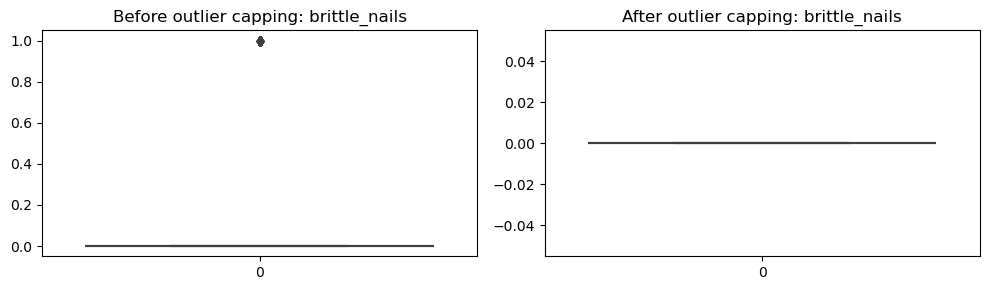

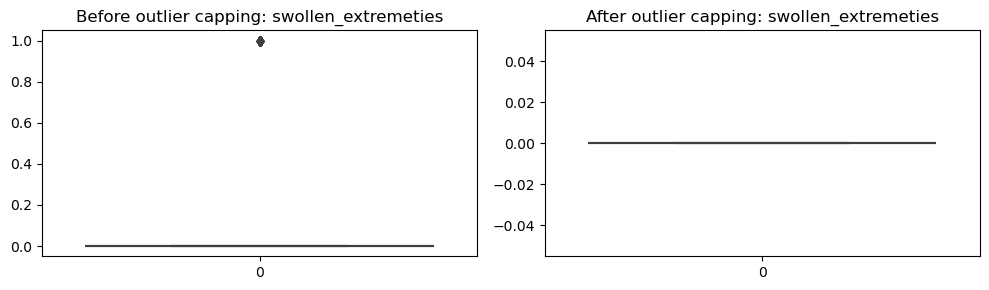

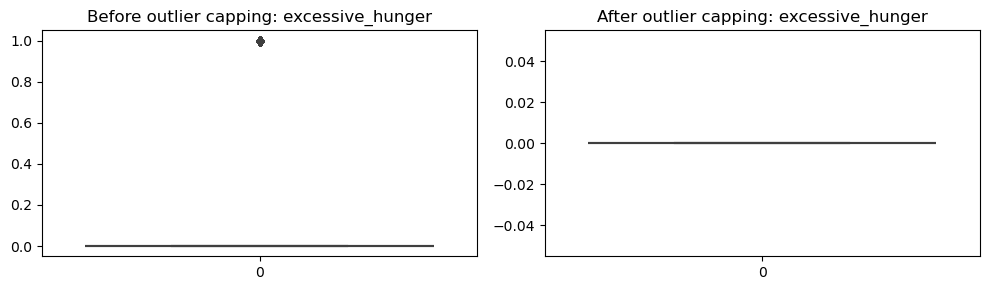

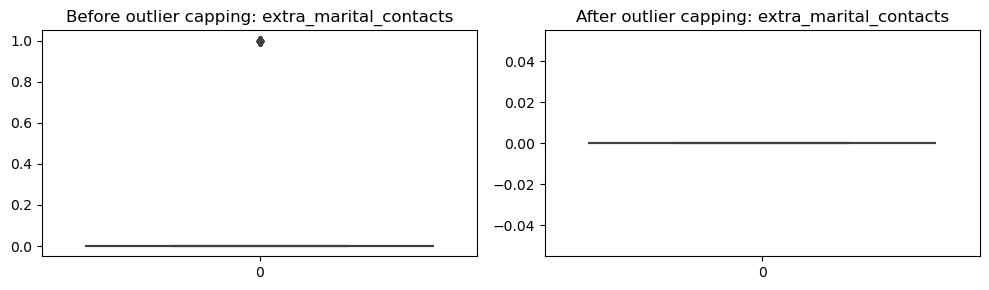

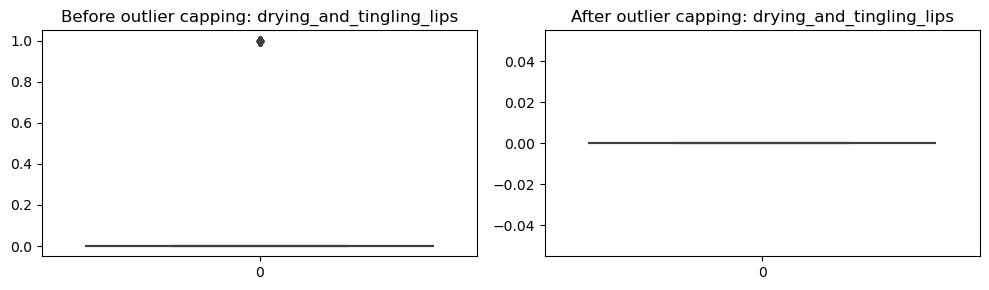

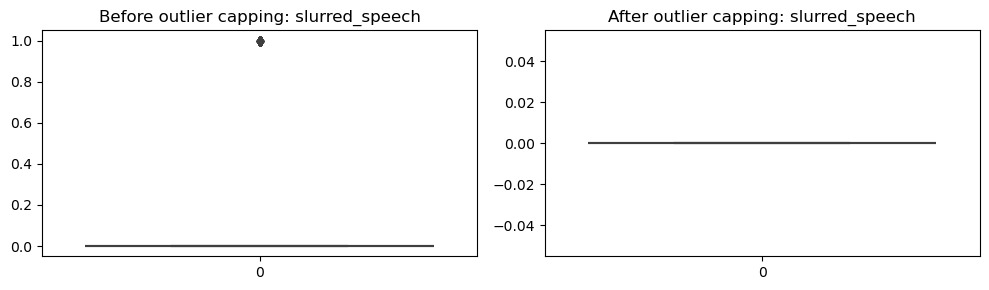

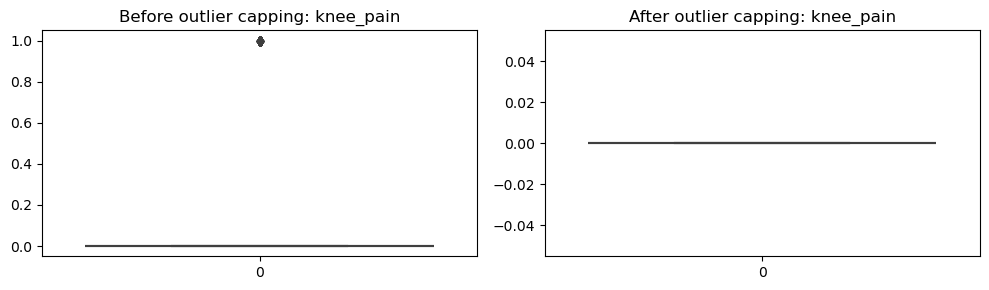

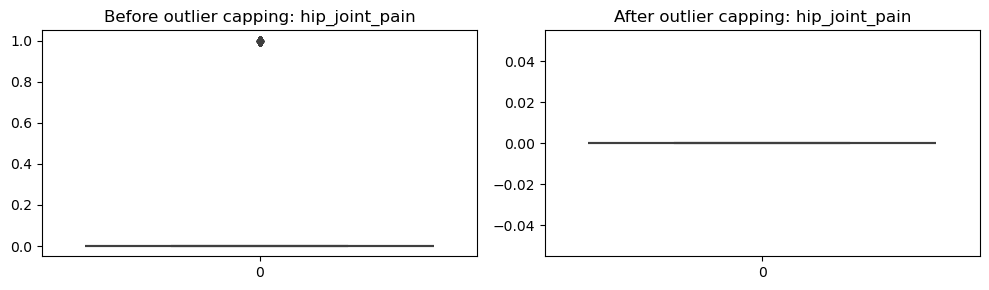

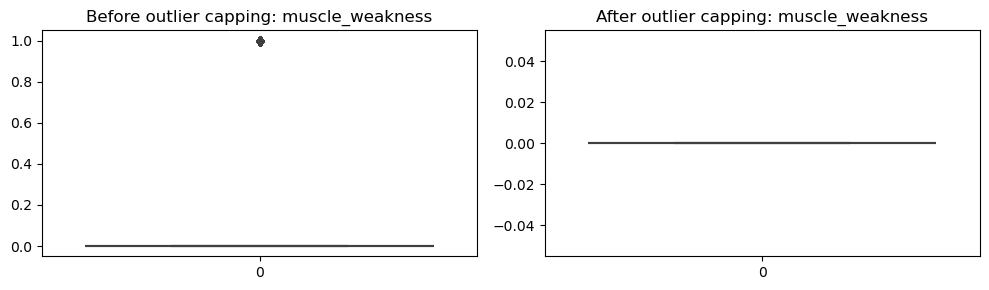

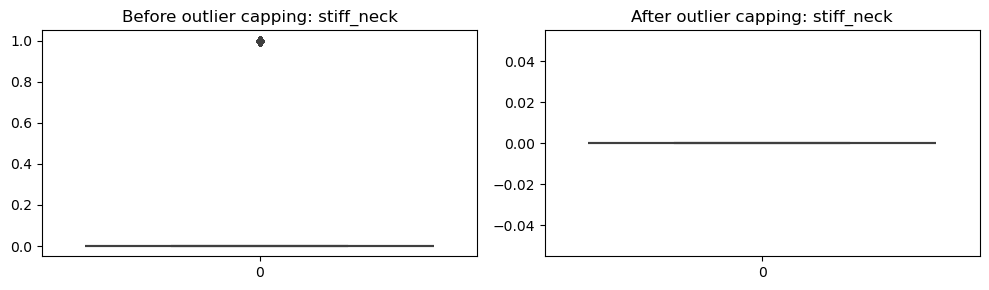

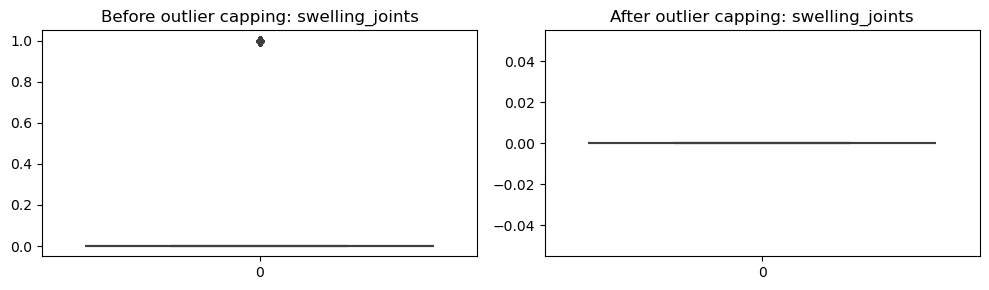

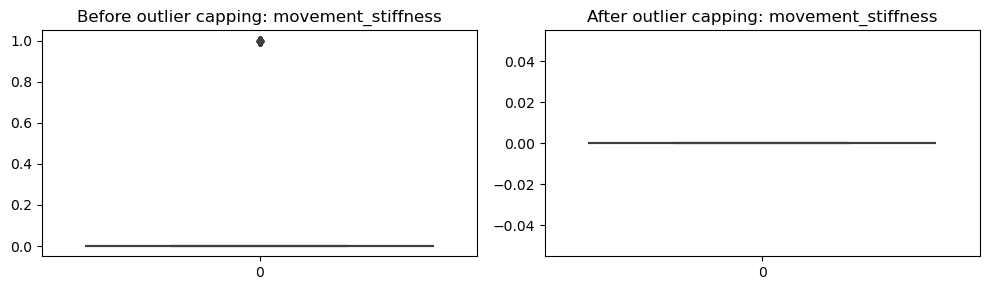

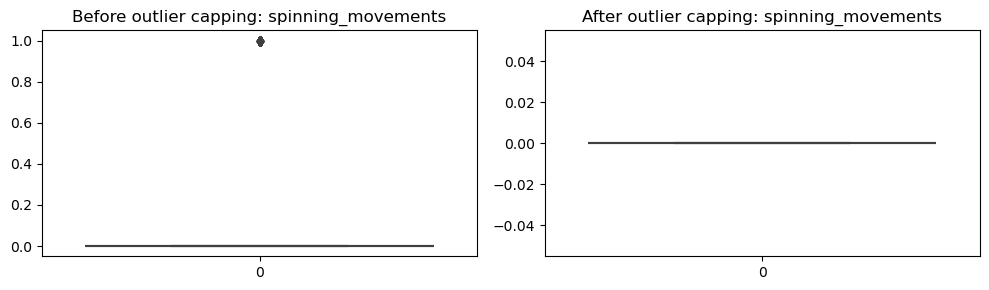

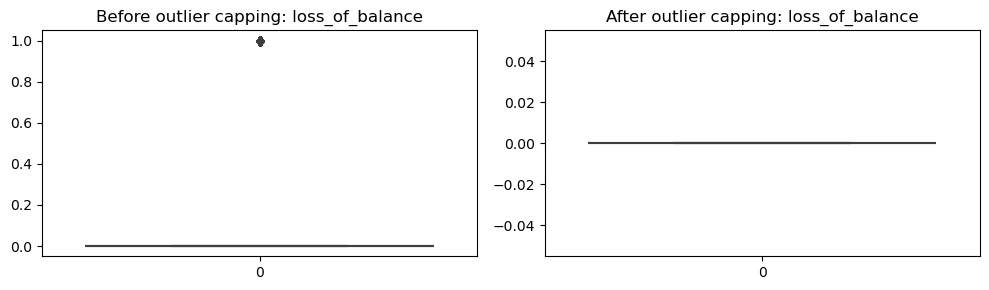

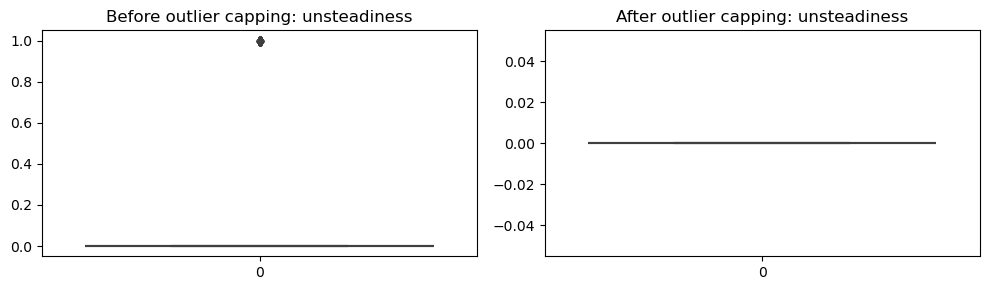

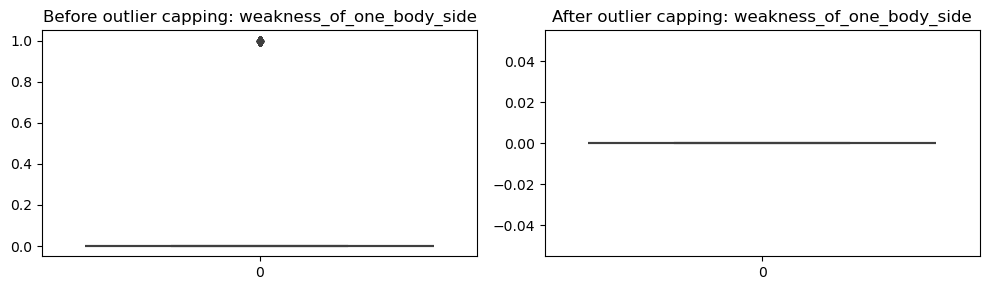

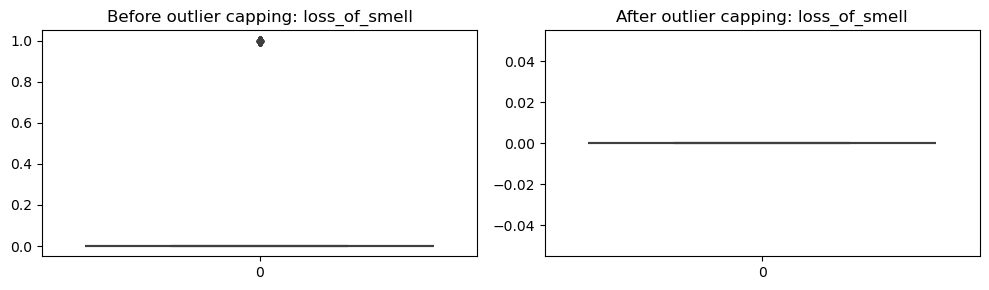

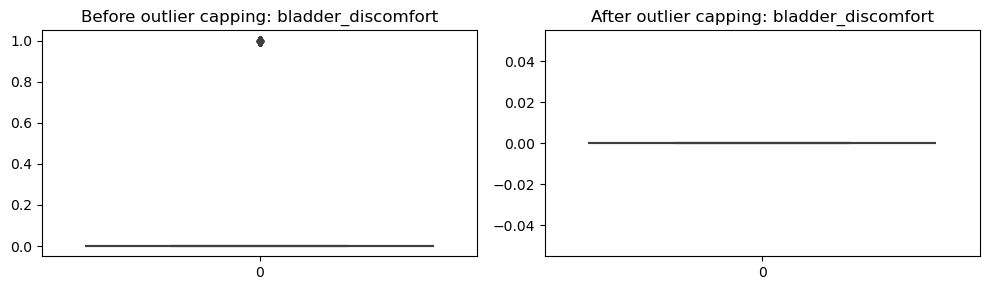

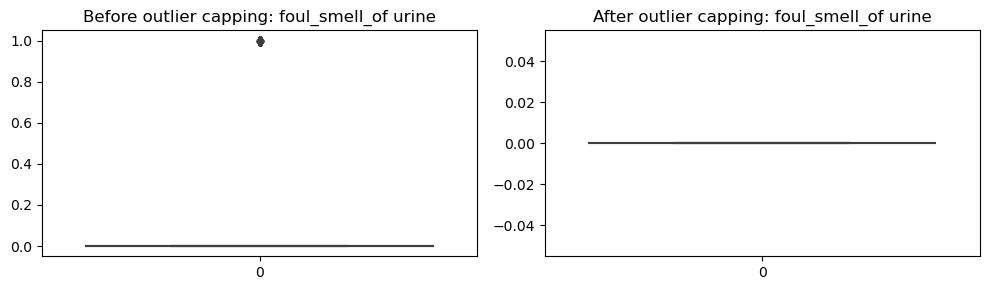

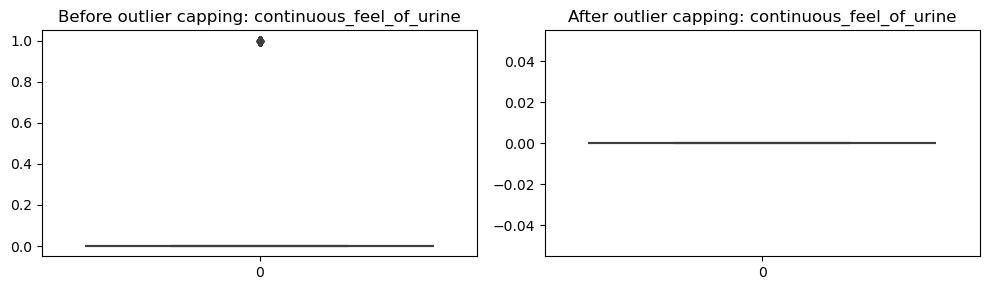

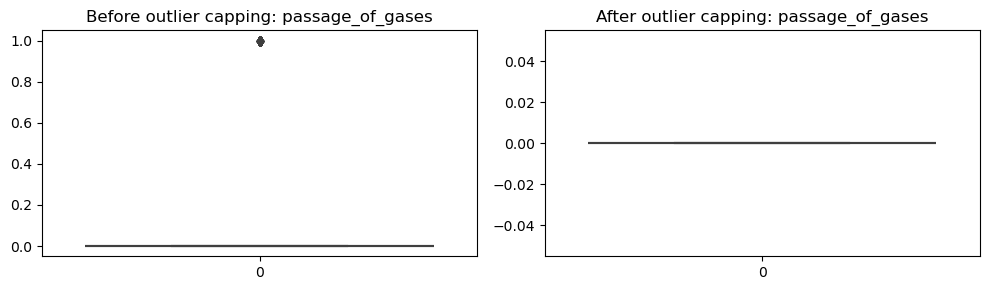

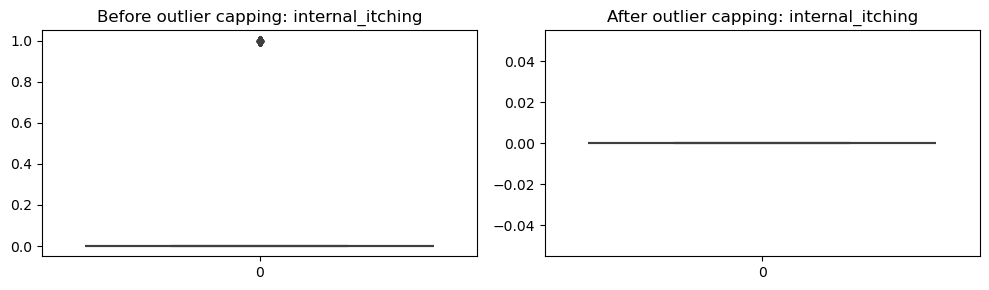

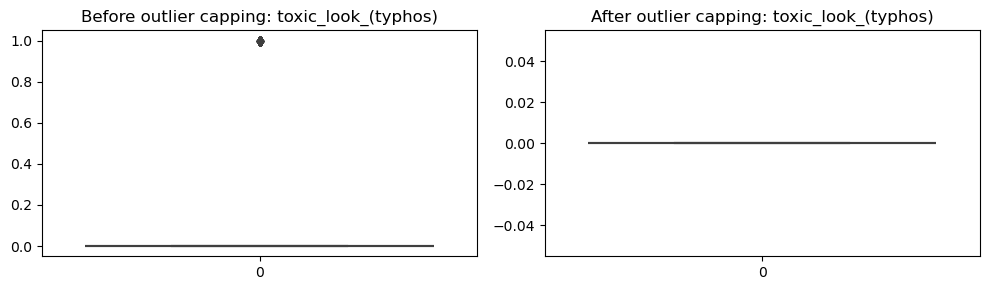

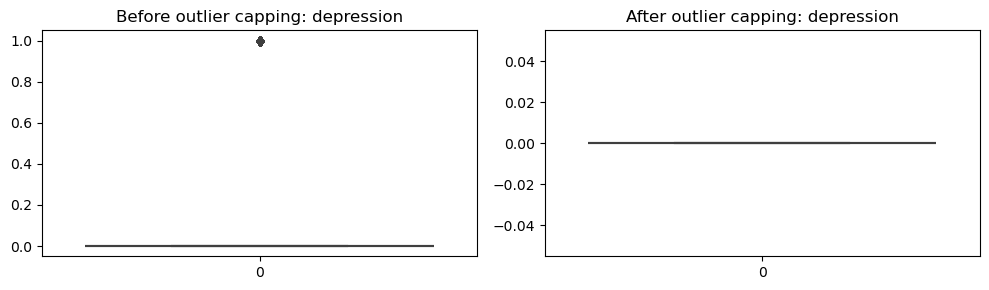

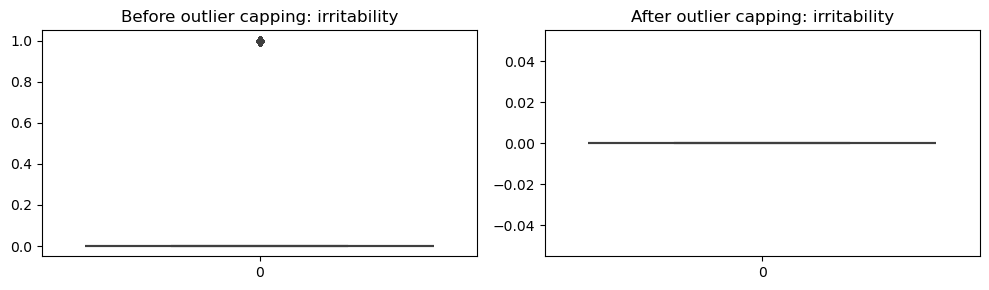

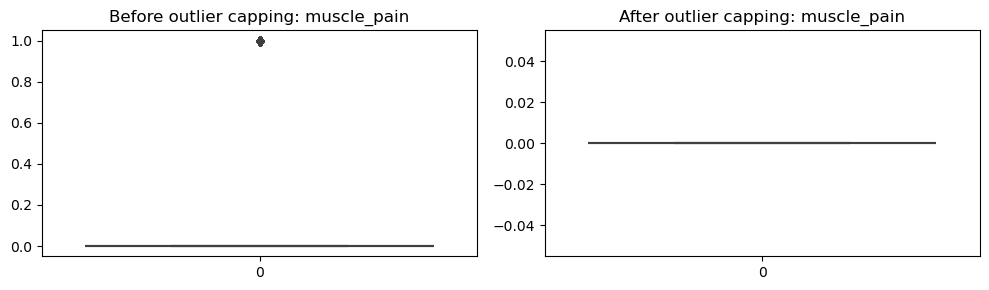

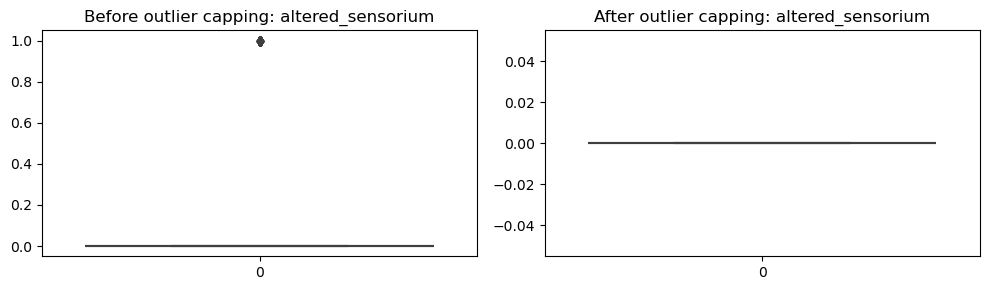

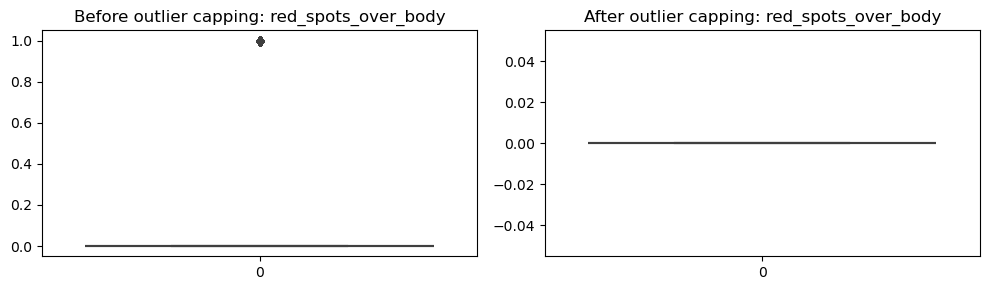

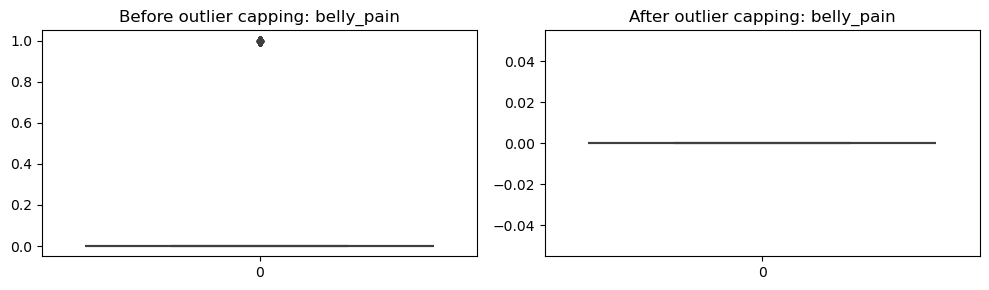

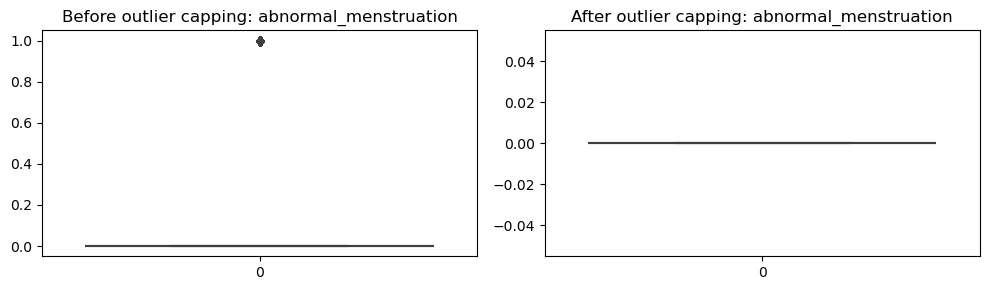

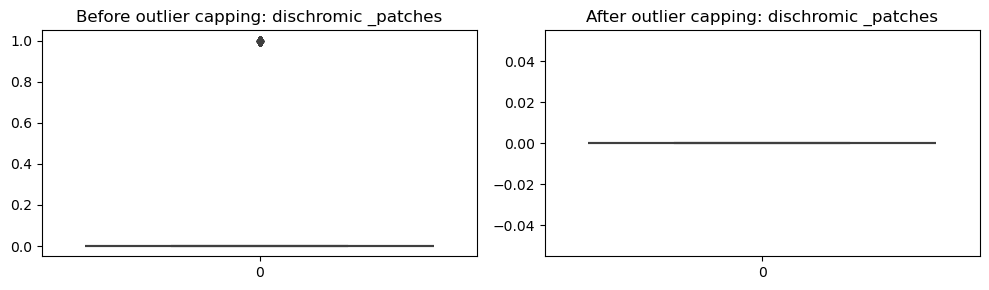

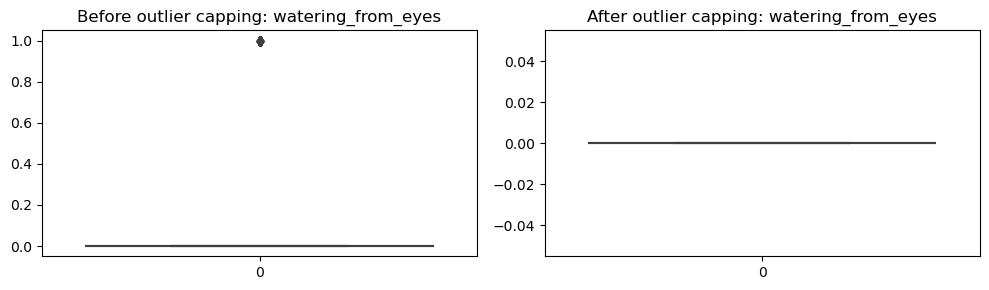

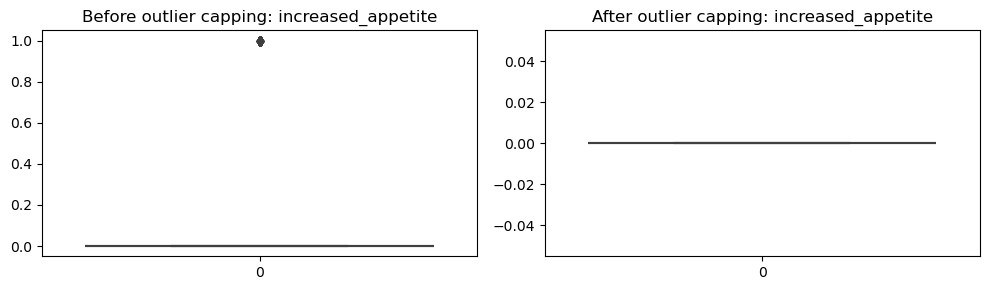

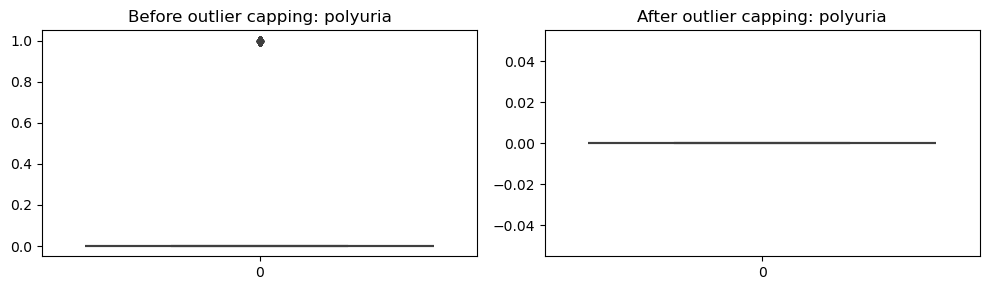

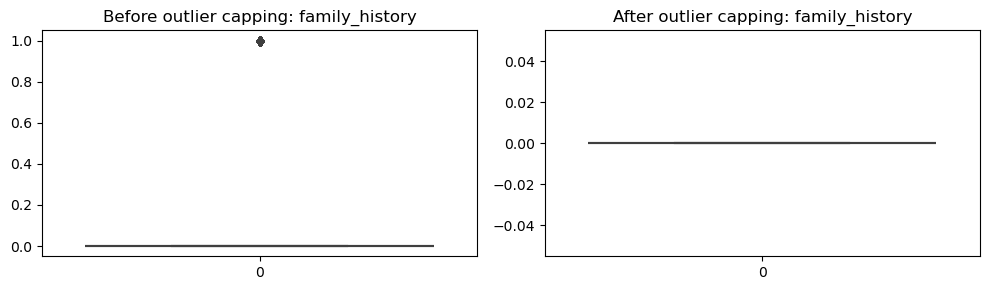

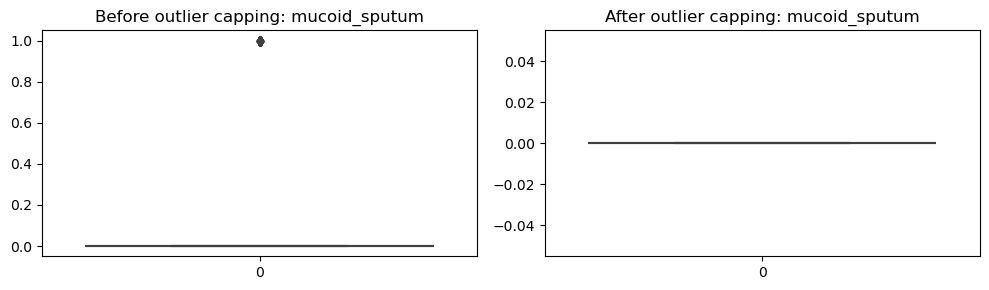

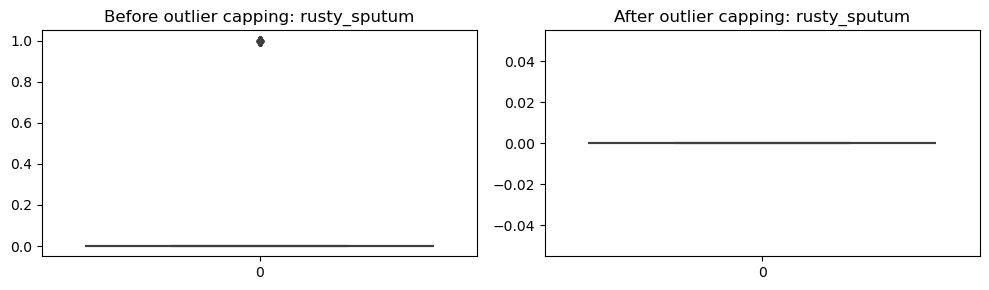

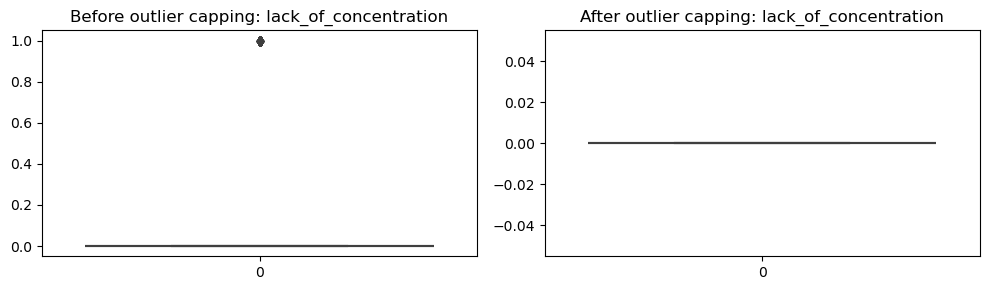

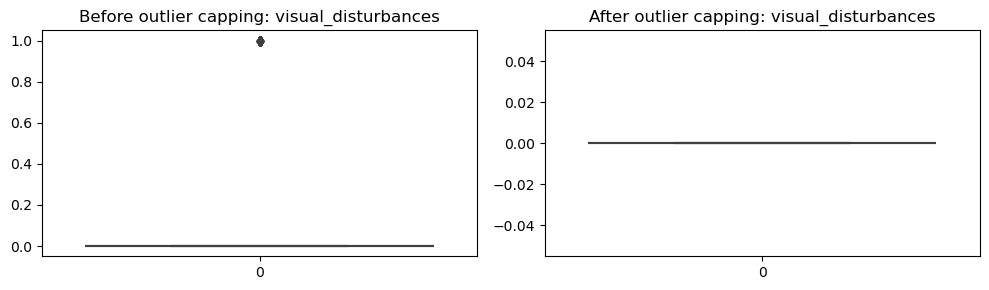

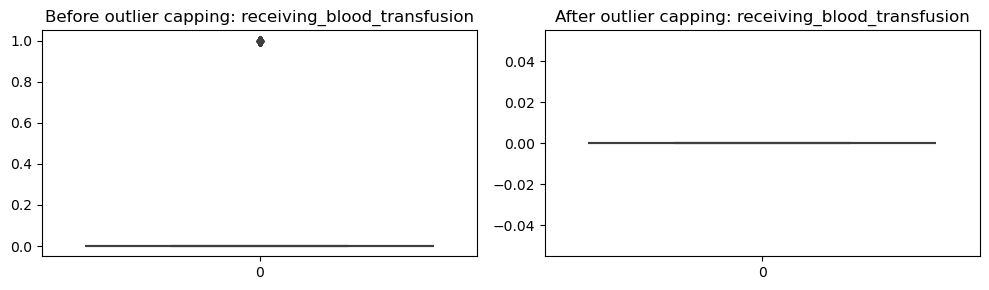

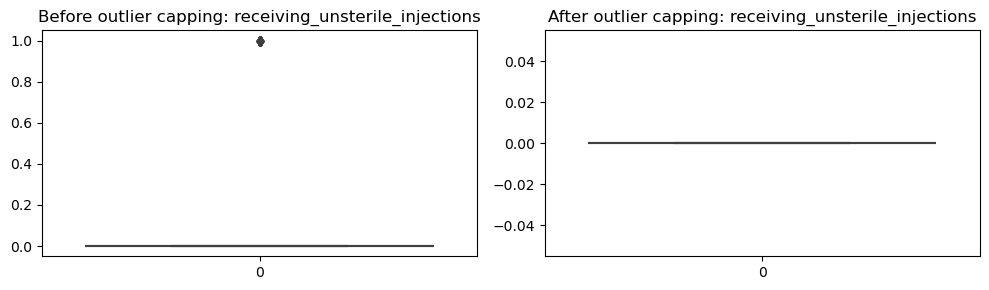

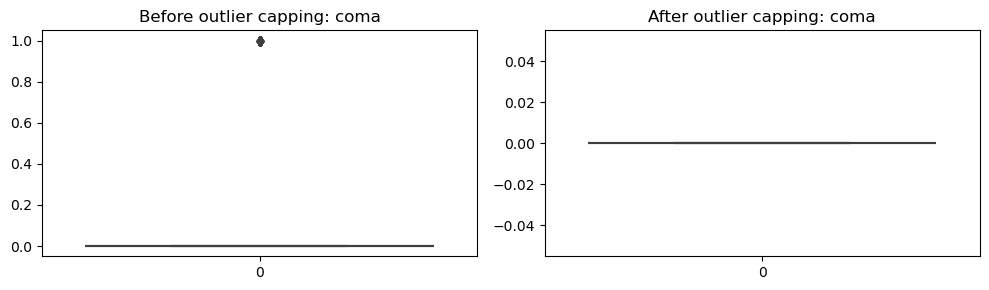

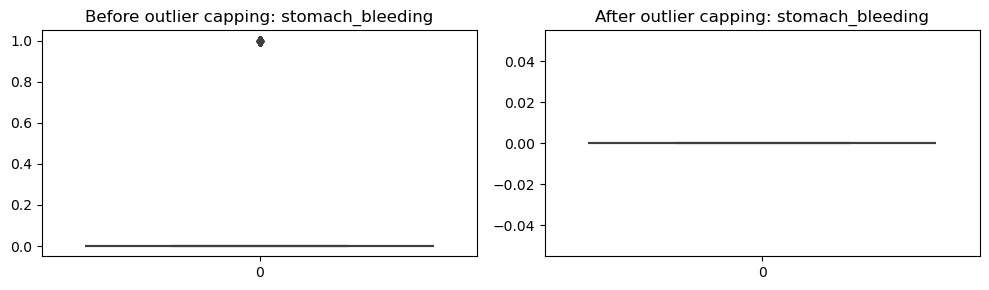

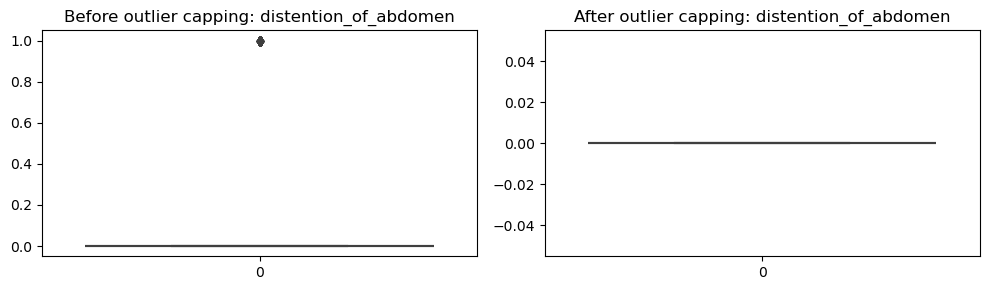

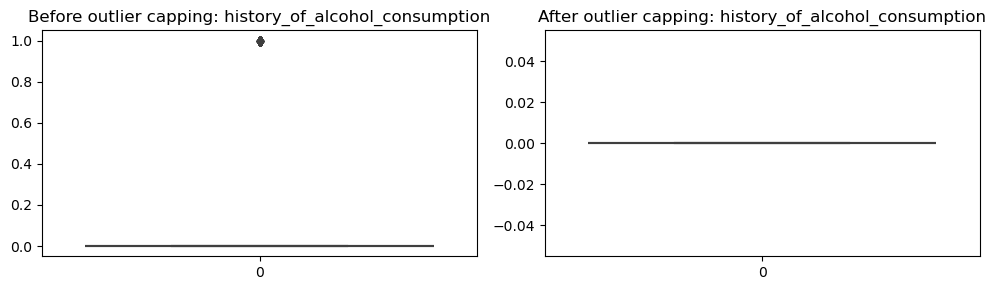

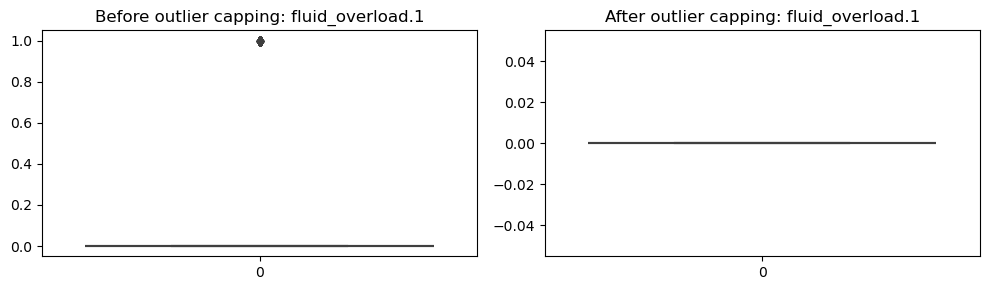

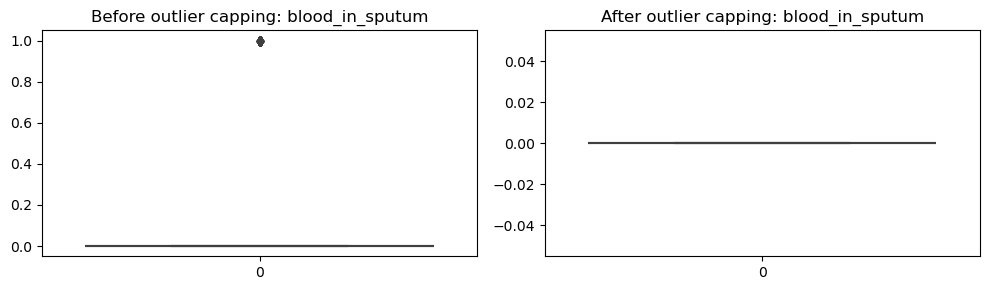

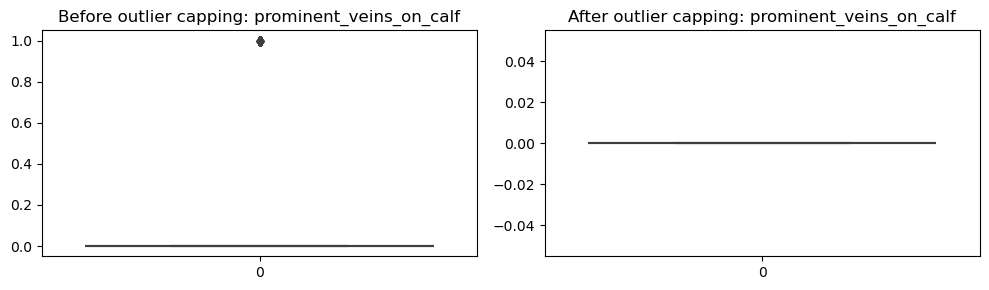

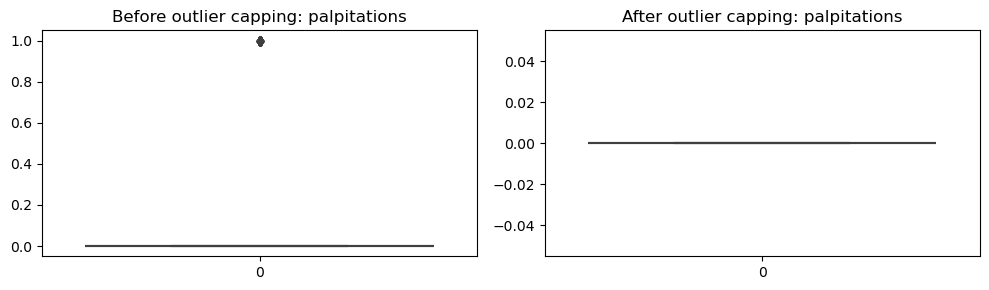

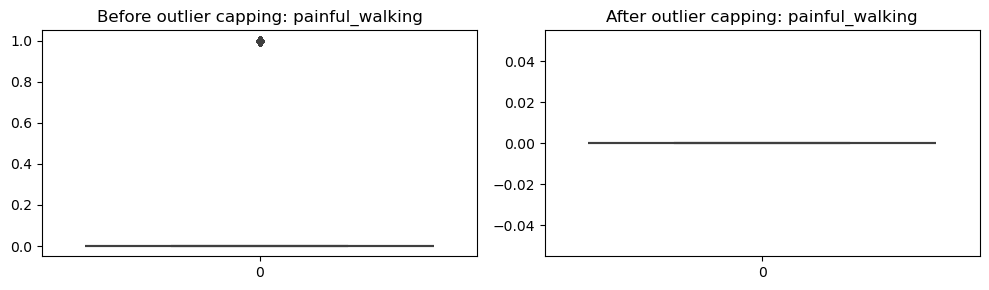

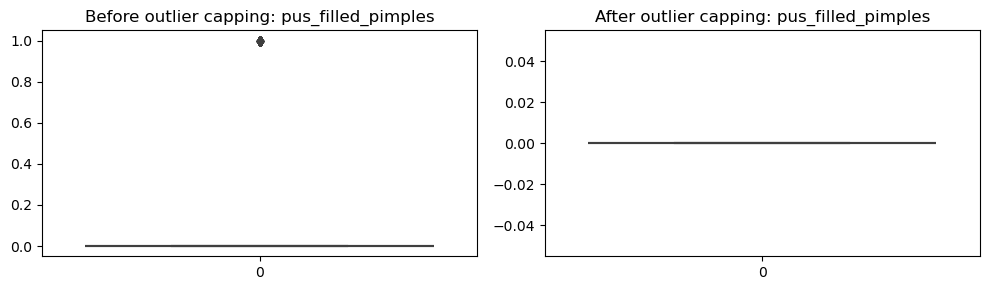

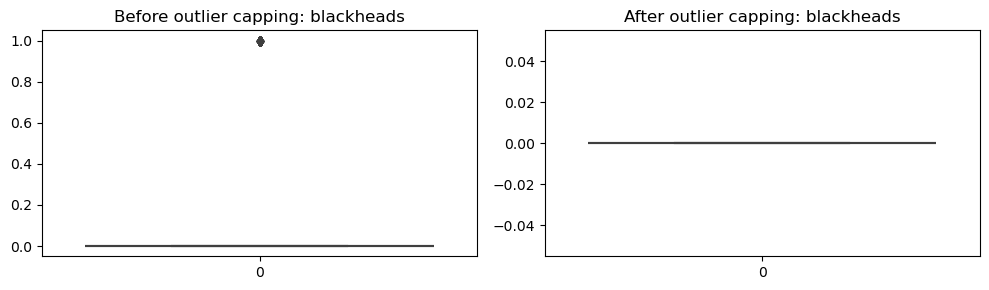

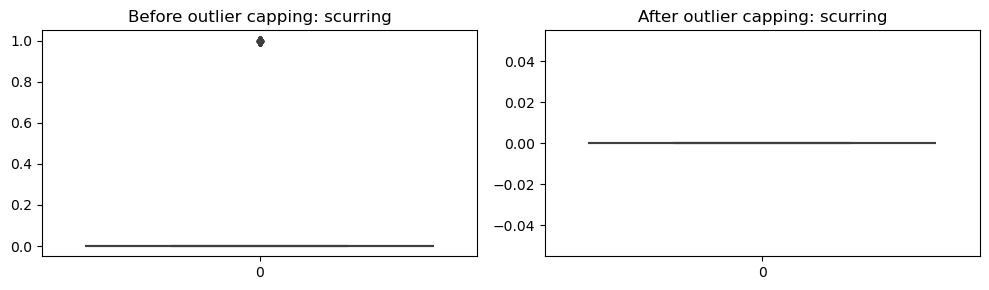

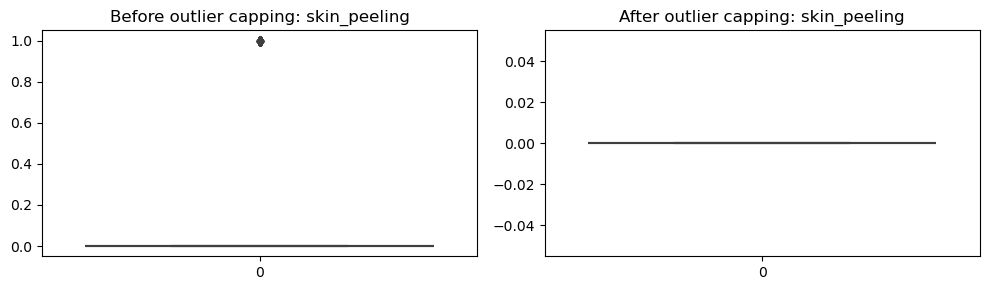

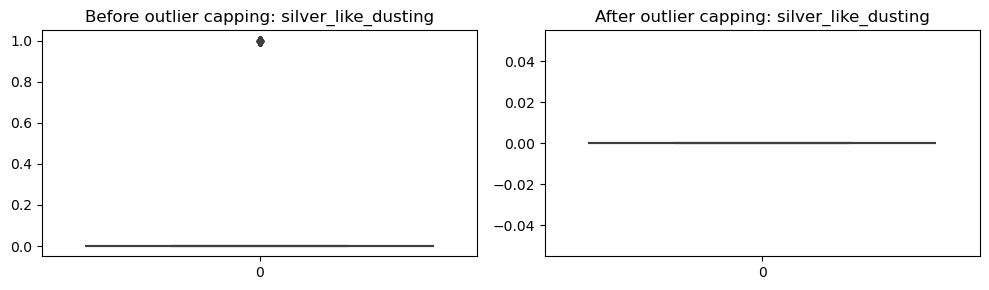

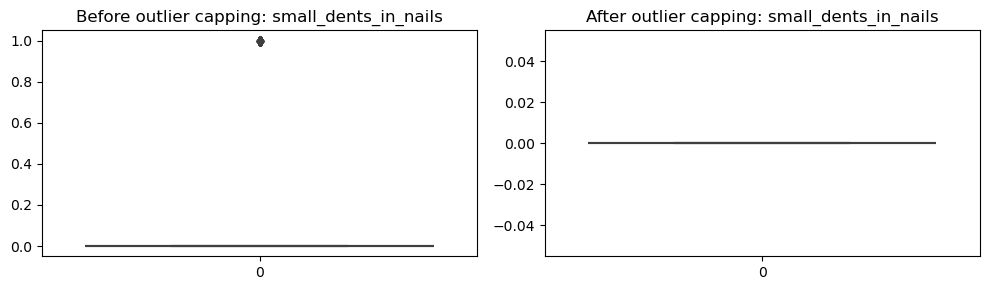

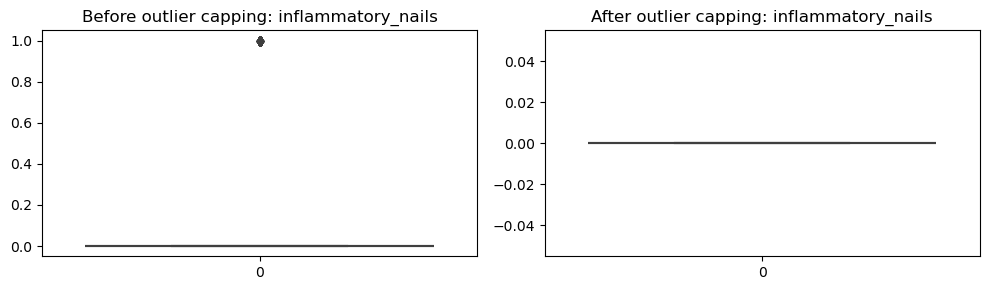

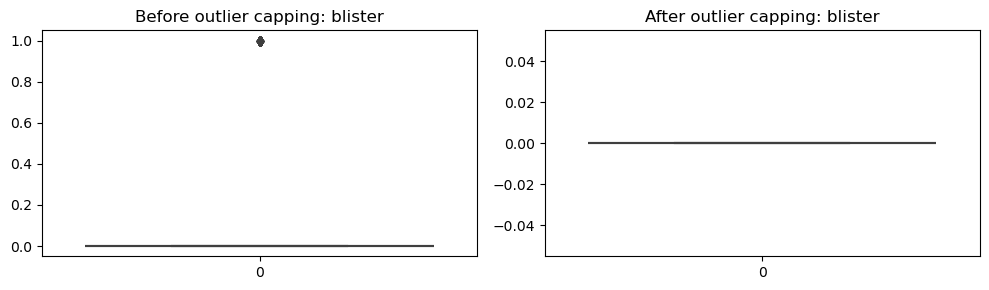

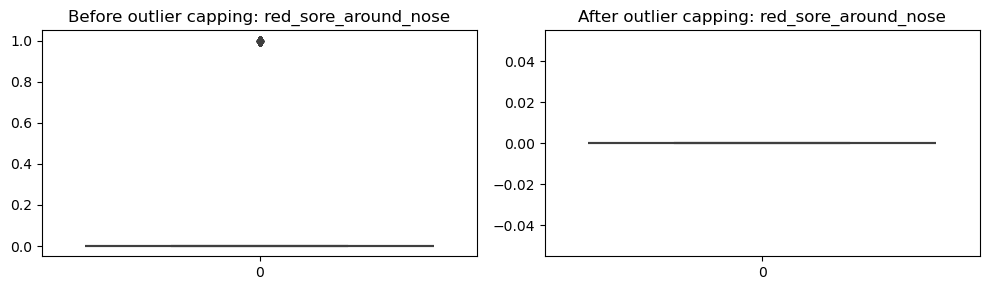

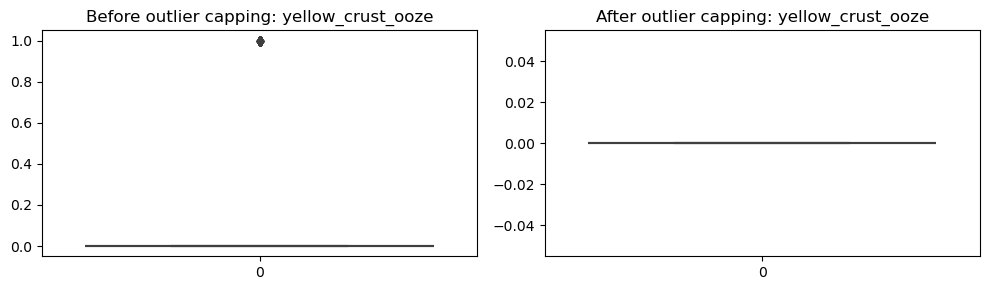

In [16]:
def boxplot_outlier(df_outlier, clean_df, outlier_indices):
    for column in df_outlier.select_dtypes(include = np.number).columns:
        fig, axes = plt.subplots(1,2, figsize=(10,3))
        #Plotting boxplot before capping
        sns.boxplot(data = df_outlier[column], ax = axes[0])
        
        # plotting boxplot after capping
        sns.boxplot(data = clean_df[column], ax = axes[1])
        axes[0].set_title(f'Before outlier capping: {column}')
        axes[1].set_title(f'After outlier capping: {column}')
        
        plt.tight_layout()
        plt.show()

boxplot_outlier(df_outlier = df_train, clean_df = df_train_clean, outlier_indices=outliers)

## c.  Visualization

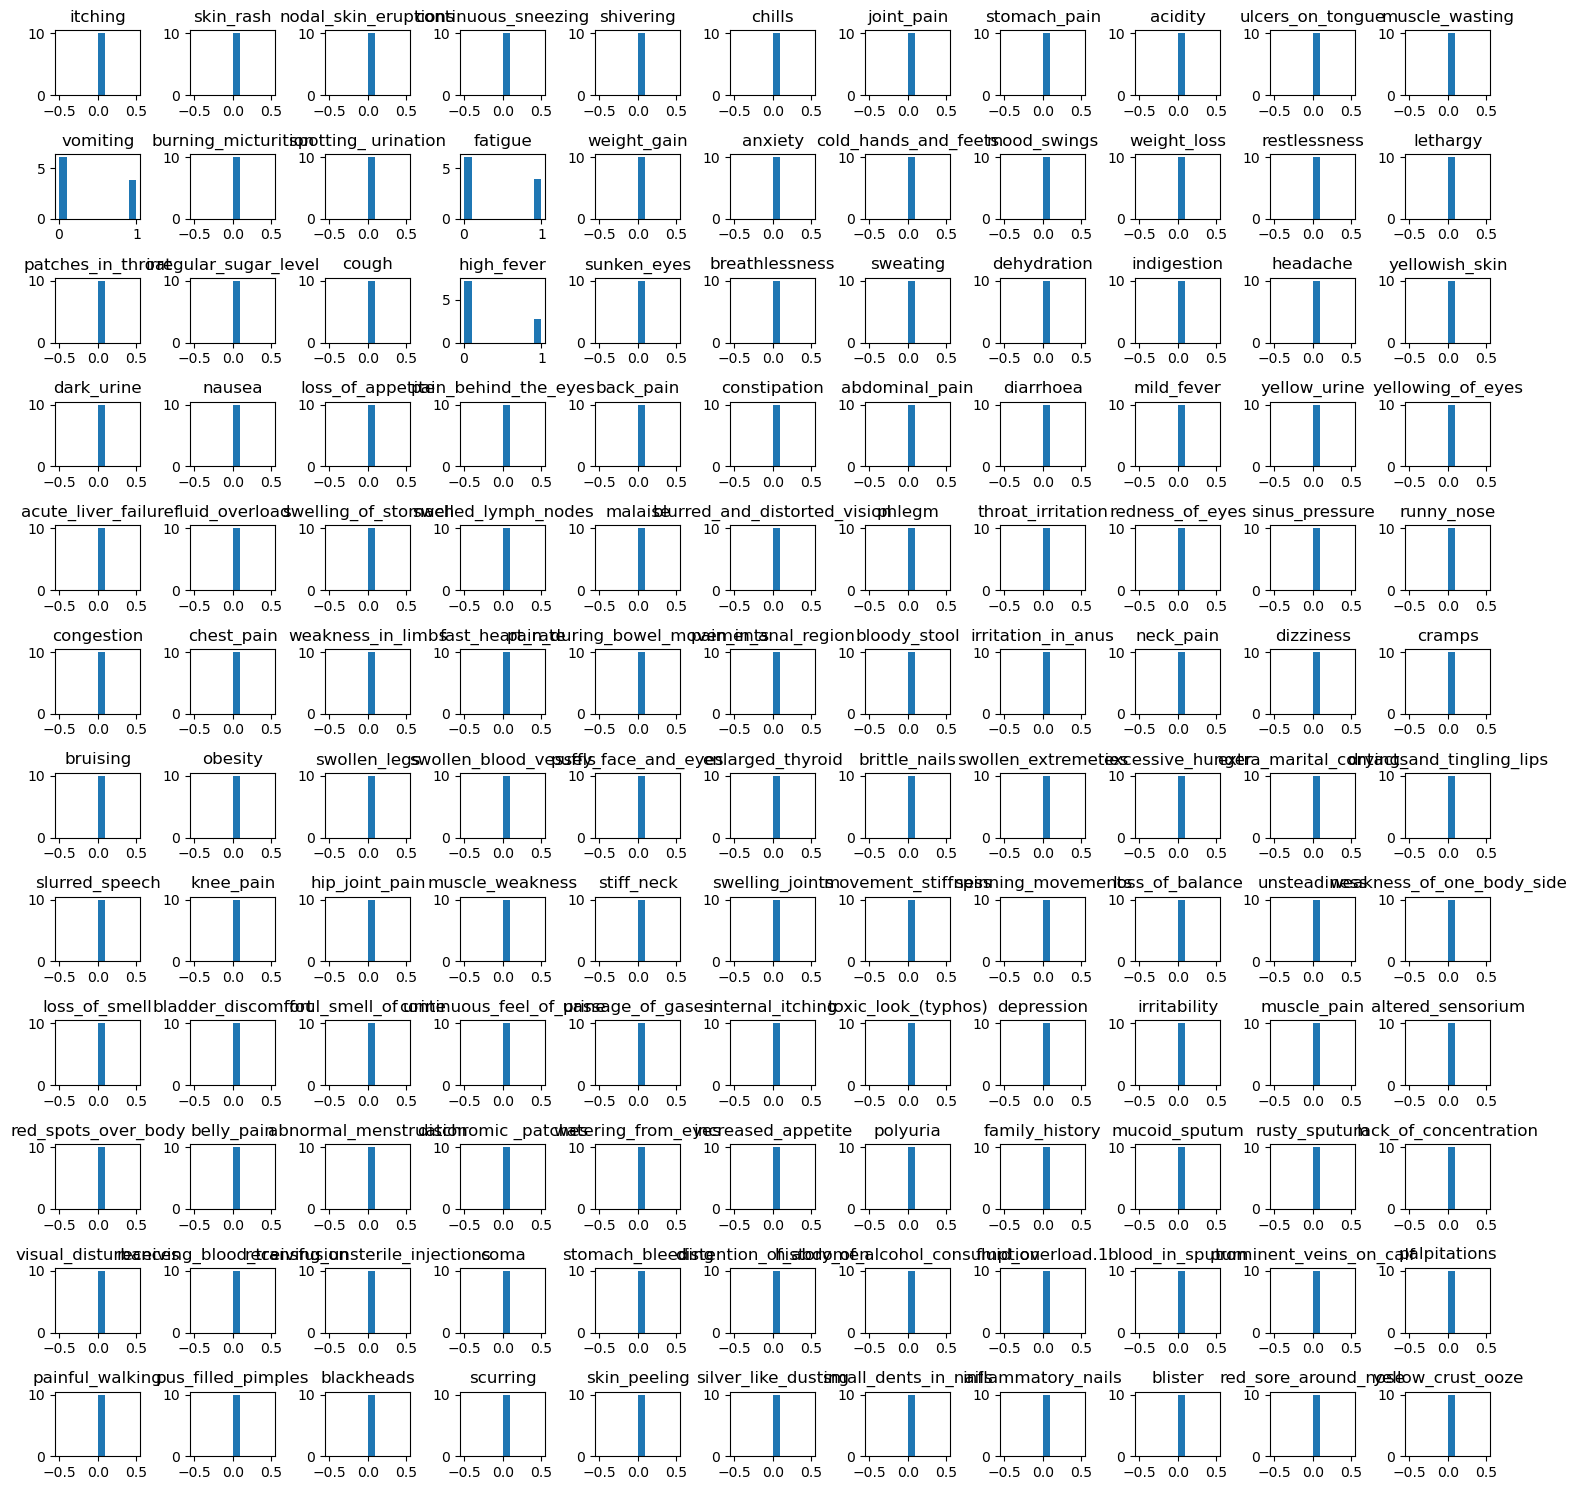

In [17]:
df_train_clean.hist(figsize = (15,15), density = True, grid = False)
plt.tight_layout()
plt.show()

## d. Encoding

In [18]:
# encoding target varible prognosis using labelencoder
label_encoder = LabelEncoder()
df_train_clean['prognosis'] = label_encoder.fit_transform(df_train_clean['prognosis'])

In [19]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: float64(132), int32(1)
memory usage: 5.0 MB


# Modeling

In [20]:
X = df_train_clean.drop(columns = 'prognosis')
y = df_train_clean['prognosis']

In [21]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 24 )
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((3690, 132), (1230, 132), (3690,), (1230,))

## a. Using K-Fold Cross-Validation for model selection 

In [33]:
def score_matrix(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

models  = {
    "SVC":SVC(), 
    "Gaussian Naive Bayes Classifier":GaussianNB(), 
    "Random Forest":RandomForestClassifier(random_state=18)
}

for model_name in models:
    model = models[model_name]
    score = cross_val_score(model, X, y,  cv = 10, n_jobs = -1, scoring = score_matrix)
    
    print('*' * 100)
    print(f'Model : {model_name}')
    print(f'Scores: {score}')
    print(f'Mean score: {np.mean(score)}')

****************************************************************************************************
Model : SVC
Scores: [0.17479675 0.16260163 0.16666667 0.17276423 0.17276423 0.19512195
 0.19512195 0.19512195 0.19512195 0.19512195]
Mean score: 0.18252032520325204
****************************************************************************************************
Model : Gaussian NB
Scores: [0.17479675 0.16260163 0.16666667 0.17276423 0.17276423 0.17073171
 0.17073171 0.17073171 0.17073171 0.17073171]
Mean score: 0.17032520325203251
****************************************************************************************************
Model : Random Forest
Scores: [0.17479675 0.16260163 0.16666667 0.17479675 0.17276423 0.19512195
 0.19512195 0.19512195 0.19512195 0.19512195]
Mean score: 0.18272357723577234


## b. Building robust classifier by combining all models

Accuracy on train data by SVC: 19.27%
Accuracy on test data by SVC: 14.39%


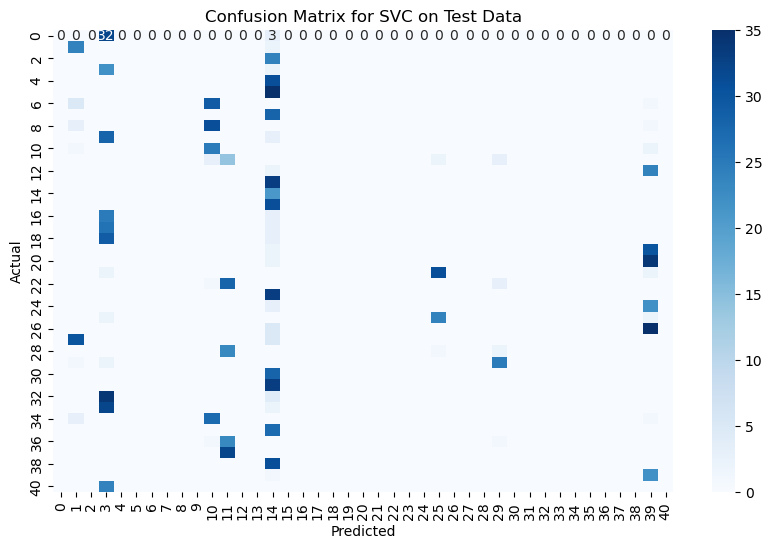

Accuracy on train data by Gaussian NB: 16.86%
Accuracy on test data by Gaussian NB: 14.31%


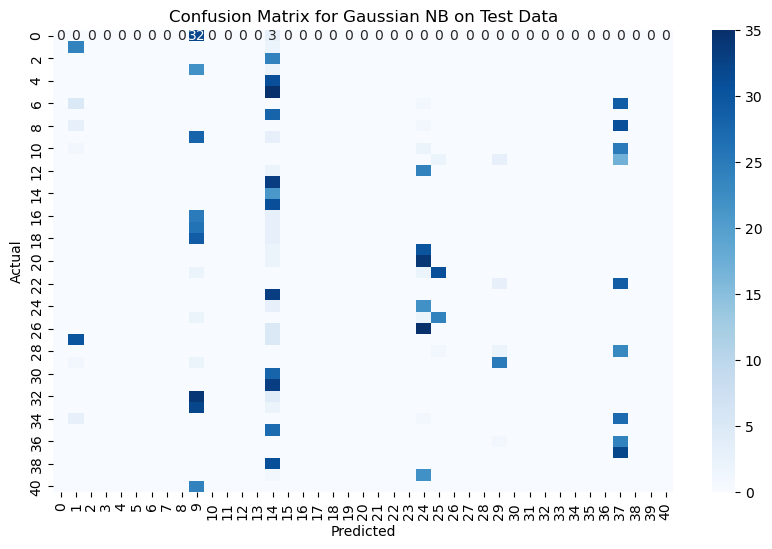

Accuracy on train data by Random Forest: 19.27%
Accuracy on test data by Random Forest: 14.39%


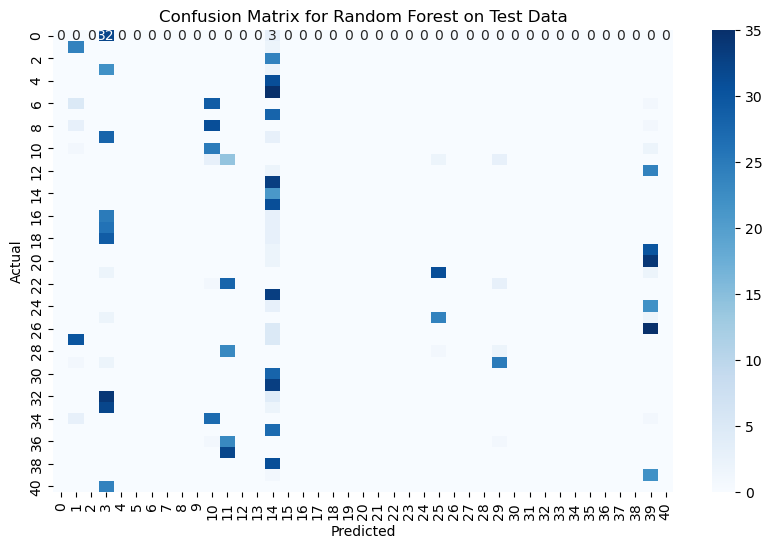

In [38]:
for model_name in models:
    model = models[model_name]
    model_fit = model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    conf_matrix = confusion_matrix(y_test, test_preds)
    accur_score_train = accuracy_score(y_train, train_preds)
    accur_score_test = accuracy_score(y_test, test_preds)
    
    print(f"Accuracy on train data by {model_name}: {accur_score_train * 100:.2f}%")
    print(f"Accuracy on test data by {model_name}: {accur_score_test * 100:.2f}%")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} on Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()